In [1]:
import json
from datasets import load_from_disk

# Actual path
full_path = 'local_chunk_dataset/chunk2500_overlap250'

# Step 1: Load the local Hugging Face dataset
dataset = load_from_disk(full_path)

In [2]:
dataset

Dataset({
    features: ['markdown_text', 'pdf_metadata', 'header_metadata', 'chunk_metadata'],
    num_rows: 12985
})

In [3]:
dataset[0]

{'markdown_text': '## **Frustratingly Easy Domain Adaptation**  \n### **Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
 'pdf_metadata': {'id': '0907.1815',
  'title': 'Frustratingly Easy Domain Adaptation',
  'categories': ['cs.LG', 'cs.CL']},
 'header_metadata': {'Header 1': None,
  'Header 2': '**Frustratingly Easy Domain Adaptation**',
  'Header 3': '**Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
  'Header 4': None,
  'Header 5': None},
 'chunk_metadata': {'chunk_type': 'title'}}

In [4]:
from qdrant_vector_store.data_embedding_utils import markdown_to_text

In [5]:
import json
from datasets import load_dataset

# Step 2: Define a function to extract and flatten nested fields
def extract_all_fields(example):
    # Flatten `pdf_metadata`
    pdf_metadata = example.get('pdf_metadata', {})
    example['pdf_id'] = pdf_metadata.get('id', None)
    example['pdf_title'] = pdf_metadata.get('title', None)
    example['pdf_categories'] = pdf_metadata.get('categories', [])

    # Flatten `header_metadata`
    header_metadata = example.get('header_metadata', {})
    example['header_1'] = header_metadata.get('Header 1', None)
    example['header_2'] = header_metadata.get('Header 2', None)
    example['header_3'] = header_metadata.get('Header 3', None)
    example['header_4'] = header_metadata.get('Header 4', None)
    example['header_5'] = header_metadata.get('Header 5', None)

    # Flatten `chunk_metadata`
    chunk_metadata = example.get('chunk_metadata', {})
    example['chunk_type'] = chunk_metadata.get('chunk_type', None)

    # Apply markdown_to_text to clean the markdown_text field
    markdown_text = example.get('markdown_text', '')
    example['plaintext'] = markdown_to_text(markdown_text)

    # Return the updated example with all fields moved to the top level
    return example

# Step 3: Apply the function to map over the dataset and flatten all necessary fields
dataset = dataset.map(extract_all_fields)

# Step 4: Extract all the data from the 'train' split and prepare it for JSON
extracted_data = [example for example in dataset]  # Extract all fields for the 'train' split

# Step 5: Save the extracted data into a JSON file
with open('full_dataset.json', 'w') as json_file:
    json.dump(extracted_data, json_file, indent=4)

print("Dataset saved to full_dataset.json")

Dataset saved to full_dataset.json


In [6]:
dataset[0]

{'markdown_text': '## **Frustratingly Easy Domain Adaptation**  \n### **Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
 'pdf_metadata': {'id': '0907.1815',
  'title': 'Frustratingly Easy Domain Adaptation',
  'categories': ['cs.LG', 'cs.CL']},
 'header_metadata': {'Header 1': None,
  'Header 2': '**Frustratingly Easy Domain Adaptation**',
  'Header 3': '**Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
  'Header 4': None,
  'Header 5': None},
 'chunk_metadata': {'chunk_type': 'title'},
 'pdf_id': '0907.1815',
 'pdf_title': 'Frustratingly Easy Domain Adaptation',
 'pdf_categories': ['cs.LG', 'cs.CL'],
 'header_1': None,
 'header_2': '**Frustratingly Easy Domain Adaptation**',
 'header_3': '**Hal Daum´e III** School of Computing University of Utah Salt Lake City, Utah 84112 `me@hal3.name`',
 'header_4': None,
 'header_5': None,
 'chunk_type': 'title',
 'plaintext': 'Frustratingly Easy

In [7]:
hand_labled_dataset = load_dataset("json", data_files="hand_labeled_subset.json") # For a single local file

In [8]:
hand_labled_dataset['train'][0].keys()

dict_keys(['id', 'annotations', 'file_upload', 'drafts', 'predictions', 'data', 'meta', 'created_at', 'updated_at', 'inner_id', 'total_annotations', 'cancelled_annotations', 'total_predictions', 'comment_count', 'unresolved_comment_count', 'last_comment_updated_at', 'project', 'updated_by', 'comment_authors'])

In [9]:
def add_labels_to_data_level(dataset):
    labels = []
    
    # Extract the label from annotations for each row
    for example in dataset:
        annotations = example.get('annotations', [])
        
        if annotations:
            result = annotations[0].get('result', [])
            if result and 'value' in result[0] and 'choices' in result[0]['value']:
                label = result[0]['value']['choices'][0]
                labels.append(label)
            else:
                labels.append(None)  # Append None if the label is missing
        else:
            labels.append(None)  # Append None if annotations are missing

    # Now add the 'human_label_chunk_type' to the 'data' level of each row
    for i, example in enumerate(dataset):
        if 'data' in example:
            print(i)
            example['data']['human_label_chunk_type'] = labels[i]  # Add the label to 'data'

    return dataset

# Apply the function to the 'train' dataset
hand_labled_dataset['train'] = add_labels_to_data_level(hand_labled_dataset['train'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
def add_labels_to_data_level(example):

    # Extract the label from annotations
    annotations = example.get('annotations', [])
    if annotations:
        result = annotations[0].get('result', [])
        if result and 'value' in result[0] and 'choices' in result[0]['value']:
            label = result[0]['value']['choices'][0]
            example['data']['human_label_chunk_type'] = label.lower()  # Add the label to 'data'
        else:
            example['data']['human_label_chunk_type'] = None  # Append None if the label is missing
    else:
        example['data']['human_label_chunk_type'] = None  # Append None if annotations are missing

    return example

# Apply the function using `map` to ensure correct updates
hand_labled_dataset['train'] = hand_labled_dataset['train'].map(add_labels_to_data_level)

# Verify by checking the first row's data
print(hand_labled_dataset['train'][0]['data'].keys())  # Check the keys in the first row's 'data'
print(hand_labled_dataset['train'][0]['data']['human_label_chunk_type'])  # Check the value for the first row

# Now, you should be able to access the 'human_label_chunk_type' for each example
eval_list = []
for value in hand_labled_dataset['train']:
    eval_list.append(value['data']['human_label_chunk_type'])  # Accessing the updated field


dict_keys(['chunk_metadata', 'chunk_type', 'header_1', 'header_2', 'header_3', 'header_4', 'header_5', 'header_metadata', 'human_label_chunk_type', 'markdown_text', 'pdf_categories', 'pdf_id', 'pdf_metadata', 'pdf_title', 'plaintext'])
title


This is how many rows differ from their original labels from what I labeled.

In [11]:
# Define the filter condition: field_1 == field_2
def filter_equal(row):
    return row['data']['chunk_type'] == row['data']['human_label_chunk_type']

# Apply the filter
labeled_filtered_dataset = hand_labled_dataset['train'].filter(filter_equal)


labeled_filtered_dataset

Dataset({
    features: ['id', 'annotations', 'file_upload', 'drafts', 'predictions', 'data', 'meta', 'created_at', 'updated_at', 'inner_id', 'total_annotations', 'cancelled_annotations', 'total_predictions', 'comment_count', 'unresolved_comment_count', 'last_comment_updated_at', 'project', 'updated_by', 'comment_authors'],
    num_rows: 3982
})

In [12]:
from datasets import Dataset

# Convert the list of dictionaries into a Hugging Face Dataset
hand_labled_dataset_XGB_dataset = Dataset.from_dict({k: [d[k] for d in hand_labled_dataset['train']['data']] for k in hand_labled_dataset['train']['data'][0].keys()})

# Now `my_XGB_dataset` is a Hugging Face Dataset object
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['chunk_metadata', 'chunk_type', 'header_1', 'header_2', 'header_3', 'header_4', 'header_5', 'header_metadata', 'human_label_chunk_type', 'markdown_text', 'pdf_categories', 'pdf_id', 'pdf_metadata', 'pdf_title', 'plaintext'],
    num_rows: 4453
})

In [13]:
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['chunk_metadata', 'chunk_type', 'header_1', 'header_2', 'header_3', 'header_4', 'header_5', 'header_metadata', 'human_label_chunk_type', 'markdown_text', 'pdf_categories', 'pdf_id', 'pdf_metadata', 'pdf_title', 'plaintext'],
    num_rows: 4453
})

In [14]:
eval_list = []
none_ct = 0

for value in hand_labled_dataset_XGB_dataset:
    human_label = value['human_label_chunk_type'] 
    eval_list.append(human_label)
    if human_label is None:
        none_ct += 1

print(set(eval_list))
print(none_ct)

{'body', None, 'references', 'noise', 'title'}
8


Filter out where `None` label

In [15]:
# Define a filtering function to remove rows where 'human_label_chunk_type' is None
def filter_none_labels(example):
    return example['human_label_chunk_type'] is not None

# Apply the filter to the dataset
hand_labled_dataset_XGB_dataset = hand_labled_dataset_XGB_dataset.filter(filter_none_labels)

# Verify the result
print(f"Number of rows after filtering: {len(hand_labled_dataset_XGB_dataset)}")

Filter:   0%|          | 0/4453 [00:00<?, ? examples/s]

Number of rows after filtering: 4445


In [16]:
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['chunk_metadata', 'chunk_type', 'header_1', 'header_2', 'header_3', 'header_4', 'header_5', 'header_metadata', 'human_label_chunk_type', 'markdown_text', 'pdf_categories', 'pdf_id', 'pdf_metadata', 'pdf_title', 'plaintext'],
    num_rows: 4445
})

In [17]:
def promote_chunk_type_field(example):
    example["chunk_type"] = example["chunk_metadata"]["chunk_type"]
    return example

hand_labled_dataset_XGB_dataset = hand_labled_dataset_XGB_dataset.map(promote_chunk_type_field)
hand_labled_dataset_XGB_dataset

Map:   0%|          | 0/4445 [00:00<?, ? examples/s]

Dataset({
    features: ['chunk_metadata', 'chunk_type', 'header_1', 'header_2', 'header_3', 'header_4', 'header_5', 'header_metadata', 'human_label_chunk_type', 'markdown_text', 'pdf_categories', 'pdf_id', 'pdf_metadata', 'pdf_title', 'plaintext'],
    num_rows: 4445
})

In [18]:
# Keep only the relevant columns: 'plaintext', 'chunk_type', and 'human_label_chunk_type'
relevant_columns = ['plaintext', 'chunk_type', 'human_label_chunk_type']

# Remove all columns except for the relevant ones
hand_labled_dataset_XGB_dataset = hand_labled_dataset_XGB_dataset.select_columns(relevant_columns)

# Verify the columns left in the dataset
print(f"Remaining columns: {hand_labled_dataset_XGB_dataset.column_names}")

Remaining columns: ['plaintext', 'chunk_type', 'human_label_chunk_type']


In [19]:
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['plaintext', 'chunk_type', 'human_label_chunk_type'],
    num_rows: 4445
})

In [20]:
from collections import Counter
import math
import string
import re

def compute_all_char_metrics(example):
    """
    Compute all character-level metrics from the `plaintext` of a chunk.
    These metrics help identify noisy, low-information, or anomalous chunks
    before embeddings are generated.

    Returns a dictionary with the following fields:
    - alphabetic_char_ratio: Proportion of alphabetic characters to total
    - numeric_char_ratio: Proportion of numeric characters (0-9)
    - punctuation_char_ratio: Proportion of standard punctuation marks
    - whitespace_char_ratio: Proportion of whitespace (spaces, tabs, etc.)
    - newline_ratio: Proportion of newline characters
    - symbol_ratio: All other characters not covered above
    - pipe_to_alnum_ratio: Ratio of '|' chars to alphanumeric chars (useful for detecting table-like noise)
    - char_length: Total number of characters in the chunk
    - char_entropy: Shannon entropy of the character distribution — lower = repetitive, higher = diverse
    - unique_char_ratio: Unique characters divided by total characters
    - top1_char_ratio: Frequency of most common character over total
    - top3_char_ratio: Sum of frequencies of top 3 characters over total
    - year_count: Count of 4-digit numbers likely to be years (e.g., 1999, 2021)
    - et_al_count: Count of occurrences of the phrase "et al."
    - starts_with_number_or_bracket: Whether the chunk starts with a number or bracket (common in references)
    - author_pattern_count: Count of patterns resembling author names (e.g., "Lastname, F.")
    """

    text = example["plaintext"]
    text_lower = text.lower()
    total_chars = len(text)

    # Early exit for empty strings
    if total_chars == 0:
        return {
            "alphabetic_char_ratio": 0.0,
            "numeric_char_ratio": 0.0,
            "punctuation_char_ratio": 0.0,
            "whitespace_char_ratio": 0.0,
            "newline_ratio": 0.0,
            "symbol_ratio": 0.0,
            "pipe_to_alnum_ratio": 0.0,
            "char_length": 0,
            "char_entropy": 0.0,
            "unique_char_ratio": 0.0,
            "top1_char_ratio": 0.0,
            "top3_char_ratio": 0.0,
            "year_count": 0,
            "et_al_count": 0,
            "starts_with_number_or_bracket": False,
            "author_pattern_count": 0
        }

    # Base character category counts
    alphabetic = sum(c.isalpha() for c in text)
    numeric = sum(c.isdigit() for c in text)
    punctuation = sum(c in string.punctuation for c in text)
    whitespace = sum(c.isspace() for c in text)
    newlines = text.count('\n')
    symbols = total_chars - (alphabetic + numeric + punctuation + whitespace)

    # Pipe to alphanumeric ratio
    pipe_count = text.count('|')
    alnum_count = sum(c.isalnum() for c in text)
    pipe_ratio = pipe_count / alnum_count if alnum_count > 0 else 0.0

    # Entropy-based metrics
    char_counts = Counter(text_lower)
    entropy = -sum((count / total_chars) * math.log2(count / total_chars) for count in char_counts.values())

    # Top N character ratios
    sorted_counts = sorted(char_counts.values(), reverse=True)
    top1_ratio = sorted_counts[0] / total_chars if sorted_counts else 0.0
    top3_ratio = sum(sorted_counts[:3]) / total_chars if len(sorted_counts) >= 3 else top1_ratio

    # Additional metrics

    # Year count (4-digit numbers)
    year_count = len(re.findall(r'\b\d{4}\b', text))

    # "et al." count (common in citations)
    et_al_count = text.lower().count("et al.")

    # Starts with number or bracket (common in references)
    starts_with_number_or_bracket = bool(re.match(r"^[\d\[\(]", text.strip()))

    # Author pattern count (looking for patterns like "Lastname, F.")
    author_pattern_count = len(re.findall(r"\b[A-Za-z]+, [A-Za-z]\.", text))

    return {
        "alphabetic_char_ratio": alphabetic / total_chars,
        "numeric_char_ratio": numeric / total_chars,
        "punctuation_char_ratio": punctuation / total_chars,
        "whitespace_char_ratio": whitespace / total_chars,
        "newline_ratio": newlines / total_chars,
        "symbol_ratio": symbols / total_chars,
        "pipe_to_alnum_ratio": pipe_ratio, #'|' / total_alphanumeric_chars
        "char_length": total_chars,
        "char_entropy": entropy,
        "unique_char_ratio": len(char_counts) / total_chars,
        "top1_char_ratio": top1_ratio,
        "top3_char_ratio": top3_ratio,
        "year_count": year_count,
        "et_al_count": et_al_count,
        "starts_with_number_or_bracket": starts_with_number_or_bracket,
        "author_pattern_count": author_pattern_count
    }


In [21]:
hand_labled_dataset_XGB_dataset = hand_labled_dataset_XGB_dataset.map(compute_all_char_metrics)

Map:   0%|          | 0/4445 [00:00<?, ? examples/s]

In [22]:
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['plaintext', 'chunk_type', 'human_label_chunk_type', 'alphabetic_char_ratio', 'numeric_char_ratio', 'punctuation_char_ratio', 'whitespace_char_ratio', 'newline_ratio', 'symbol_ratio', 'pipe_to_alnum_ratio', 'char_length', 'char_entropy', 'unique_char_ratio', 'top1_char_ratio', 'top3_char_ratio', 'year_count', 'et_al_count', 'starts_with_number_or_bracket', 'author_pattern_count'],
    num_rows: 4445
})

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

def summarize_char_metrics_from_dataset(hf_dataset, metric_fields=None, filter_field=None, filter_value=None):
    """
    Converts HF dataset to DataFrame and computes extended descriptive statistics for character-level metrics.

    Parameters:
    - hf_dataset (Dataset): HuggingFace Dataset with character metrics
    - metric_fields (list): List of metric field names to summarize (optional)
    - filter_field (str): Top-level field to filter by (e.g., "chunk_type")
    - filter_value (Any): Value to match for filtering (e.g., "body")

    Returns:
    - pd.DataFrame: Summary statistics for each metric
    """

    # Apply filter at top level if provided
    if filter_field and filter_value is not None:
        hf_dataset = hf_dataset.filter(lambda x: x[filter_field] == filter_value)

    # Convert to DataFrame
    df = hf_dataset.to_pandas()

    # Automatically select relevant metrics if none are specified
    if metric_fields is None:
        metric_fields = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    summary_data = []

    for field in metric_fields:
        # Ensure that boolean columns are converted to numeric (0/1) for calculations
        values = df[field].dropna().astype(float)

        if len(values) == 0:
            continue

        # Quantiles and bounds for outlier detection
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Collect statistics for each metric
        summary_data.append({
            "Metric": field,
            "Mean": np.mean(values),                  # Average value
            "Median": np.median(values),              # Middle value (50th percentile)
            "Mode": values.mode().iloc[0] if not values.mode().empty else np.nan,  # Most common value
            "Std": np.std(values),                    # Standard deviation (spread of data)
            "2 Std": np.std(values) * 2,              # Two standard deviations (for filtering bounds)
            "3 Std": np.std(values) * 3,              # Three standard deviations (for stricter filtering)
            "Min": np.min(values),                    # Minimum value
            "Max": np.max(values),                    # Maximum value
            "Skew": skew(values),                     # Skewness (asymmetry of distribution)
            "Kurtosis": kurtosis(values),             # Kurtosis (tailedness of distribution)
            "IQR": iqr,                               # Interquartile Range (spread of the middle 50%)
            "% Zero": (values == 0).sum() / len(values),  # Proportion of chunks with zero for this metric
            "% Outliers Low": (values < lower_bound).sum() / len(values),  # Fraction of chunks below IQR-1.5
            "% Outliers High": (values > upper_bound).sum() / len(values), # Fraction of chunks above IQR+1.5
            "Unique Value Count": values.nunique(),   # Number of unique values
            "Support Count": len(values)              # Total number of non-null entries
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [24]:
character_metrics_summary_df = summarize_char_metrics_from_dataset(hand_labled_dataset_XGB_dataset)
character_metrics_summary_df

,Metric,Mean,Median,Mode,Std,2 Std,3 Std,Min,Max,Skew,Kurtosis,IQR,% Zero,% Outliers Low,% Outliers High,Unique Value Count,Support Count
0,alphabetic_char_ratio,0.727397,0.758454,0.000000,0.127087,0.254175,0.381262,0.0,1.000000,-3.093366,12.042942,0.099798,0.007424,0.061867,0.000225,4213,4445
1,numeric_char_ratio,0.038542,0.017266,0.000000,0.082073,0.164146,0.246218,0.0,1.000000,7.939238,79.810048,0.040459,0.075591,0.000000,0.047244,3815,4445
2,punctuation_char_ratio,0.062514,0.045550,0.000000,0.060770,0.121540,0.182310,0.0,1.000000,4.630463,40.359870,0.051002,0.017098,0.000000,0.049494,4113,4445
3,whitespace_char_ratio,0.164610,0.158652,0.000000,0.038156,0.076312,0.114468,0.0,0.470588,1.303745,8.593826,0.029967,0.006749,0.013948,0.062092,4080,4445
4,newline_ratio,0.014539,0.013109,0.000000,0.011871,0.023741,0.035612,0.0,0.428571,14.381169,396.071909,0.005670,0.039820,0.047244,0.053093,3474,4445
5,symbol_ratio,0.005362,0.001792,0.000000,0.020279,0.040559,0.060838,0.0,0.949153,29.522150,1215.180959,0.004946,0.296963,0.000000,0.098313,2632,4445
6,pipe_to_alnum_ratio,0.005581,0.000000,0.000000,0.035364,0.070727,0.106091,0.0,0.949290,14.988134,294.686401,0.000000,0.813048,0.000000,0.186952,806,4445
7,char_length,1619.686164,2001.000000,50.000000,821.116877,1642.233753,2463.350630,0.0,2497.000000,-0.648352,-1.096785,1449.000000,0.001575,0.000000,0.000000,1796,4445
8,char_entropy,4.436278,4.460377,3.827363,0.417073,0.834146,1.251220,0.0,5.044700,-7.004202,66.205990,0.258898,0.004499,0.035321,0.001125,4388,4445
9,unique_char_ratio,0.059556,0.024911,0.420000,0.111552,0.223103,0.334655,0.0,1.000000,5.342780,34.491237,0.022142,0.001575,0.000000,0.154106,3825,4445


In [25]:
def get_outlier_indices_by_metric(dataset, summary_df, std_multiplier=2, filter_field=None, filter_value=None):
    """
    Returns a dictionary mapping each metric to a list of dataset indices that are outliers
    based on Median ± (N * Std) thresholds, with optional filtering by a specific field.

    Parameters:
    - dataset (Dataset or pd.DataFrame): The dataset containing character-level metric fields.
    - summary_df (pd.DataFrame): Summary table with 'Metric', 'Median', and 'Std' columns.
    - std_multiplier (int or float): Multiplier of standard deviation used to define outlier bounds.
    - filter_field (str, optional): Column name to filter by (e.g., 'chunk_type').
    - filter_value (any, optional): Value that the filter_field must match to retain the row.

    Returns:
    - dict: {metric_name: list of index positions of outliers in the dataset}
    """
    import numpy as np

    # Convert from HF Dataset if needed
    df = dataset.to_pandas() if not isinstance(dataset, pd.DataFrame) else dataset

    # Apply optional filtering
    if filter_field and filter_value is not None:
        df = df[df[filter_field] == filter_value]

    outlier_indices = {}

    for _, row in summary_df.iterrows():
        metric = row["Metric"]
        if metric not in df.columns:
            continue

        median = row["Median"]
        std = row["Std"]
        lower = median - std_multiplier * std
        upper = median + std_multiplier * std

        indices = df[(df[metric] < lower) | (df[metric] > upper)].index.tolist()
        outlier_indices[metric] = indices

    return outlier_indices

In [26]:
import matplotlib.pyplot as plt

def plot_metric_outlier_histograms_from_hf_dataset(
    hf_dataset,
    outlier_indices_dict,
    metrics_summary,
    std_multiplier=2,
    filter_field=None,
    filter_value=None,
    bins=50,
    max_plots=None
):
    """
    Plots histograms of outlier vs non-outlier values for each metric using HuggingFace dataset.

    Parameters:
        hf_dataset (Dataset): Your HuggingFace dataset.
        outlier_indices_dict (dict): {metric: [indices]} from get_outlier_indices_by_metric.
        metrics_summary (pd.DataFrame): Summary stats for each metric (used for bounds & filtering).
        std_multiplier (int): Number of stds for threshold.
        filter_value (str): Optional filter by chunk type.
        bins (int): Number of histogram bins.
        max_plots (int): Limit number of metrics to plot (optional).
    """

    metrics_to_plot = list(outlier_indices_dict.keys())
    if max_plots:
        metrics_to_plot = metrics_to_plot[:max_plots]

    for metric in metrics_to_plot:
        outlier_indices = set(outlier_indices_dict[metric])

        non_outliers = []
        outliers = []

        for i, example in enumerate(hf_dataset):
            if filter_value and example.get(filter_field) != filter_value:
                continue
            value = example.get(metric)
            if value is None:
                continue
            if i in outlier_indices:
                outliers.append(value)
            else:
                non_outliers.append(value)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.hist(non_outliers, bins=bins, alpha=0.6, label="Not Outlier", color="green", edgecolor='black')
        plt.hist(outliers, bins=bins, alpha=0.6, label="Outlier", color="red", edgecolor='black')

        title = f"{metric} (Outlier Detection: ±{std_multiplier} std)"
        if filter_value:
            title += f" | Chunk Type: {filter_value}"

        plt.title(title)
        plt.xlabel(metric.replace("_", " ").title())
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

Filter:   0%|          | 0/4445 [00:00<?, ? examples/s]

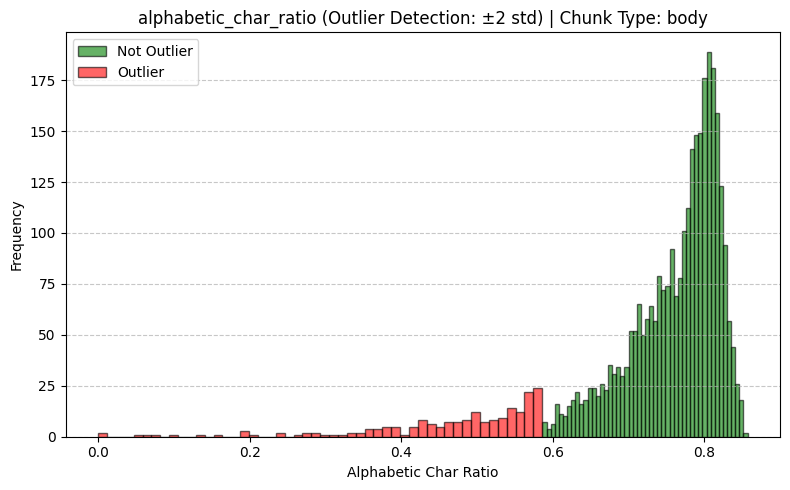

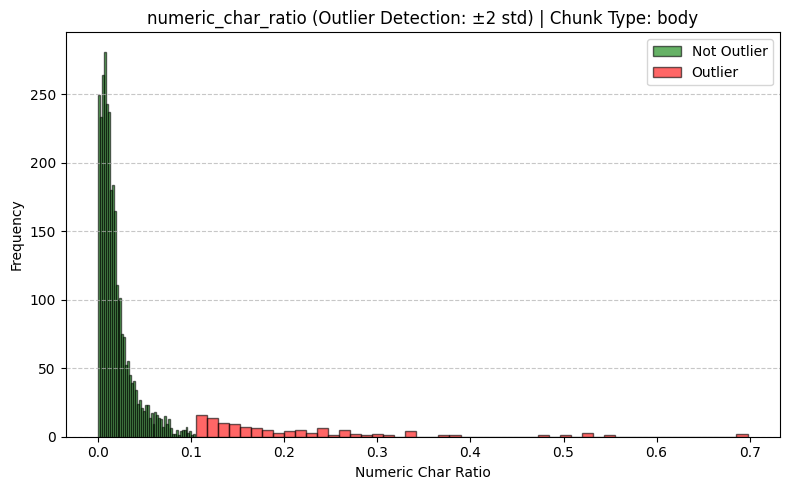

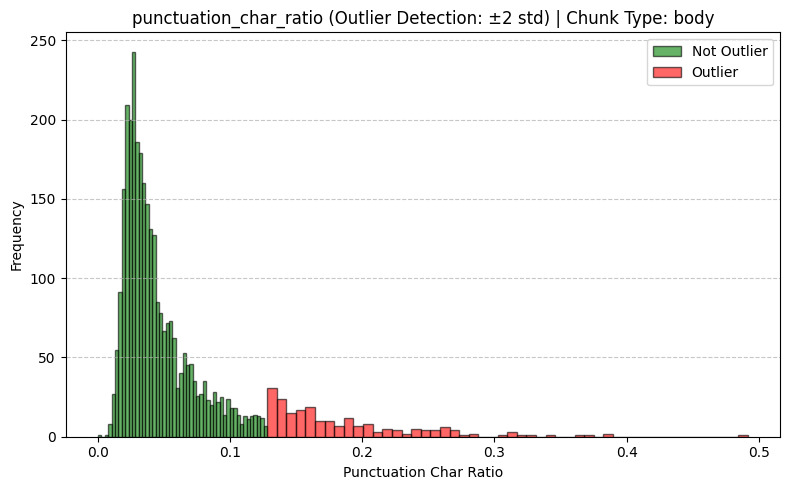

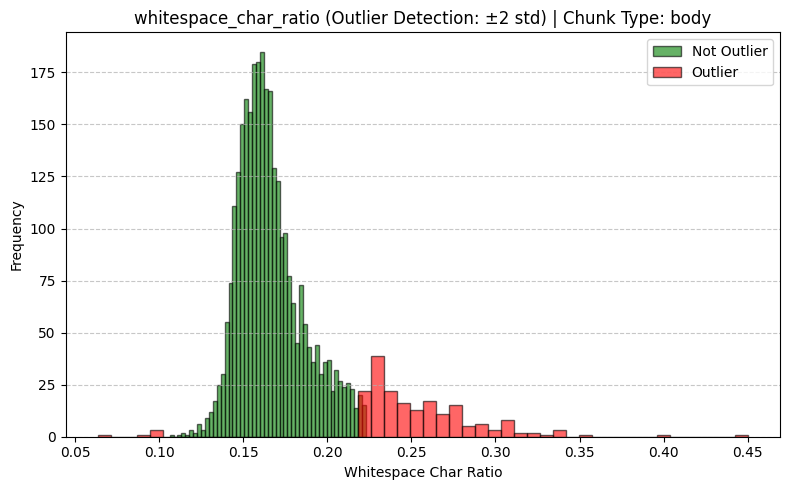

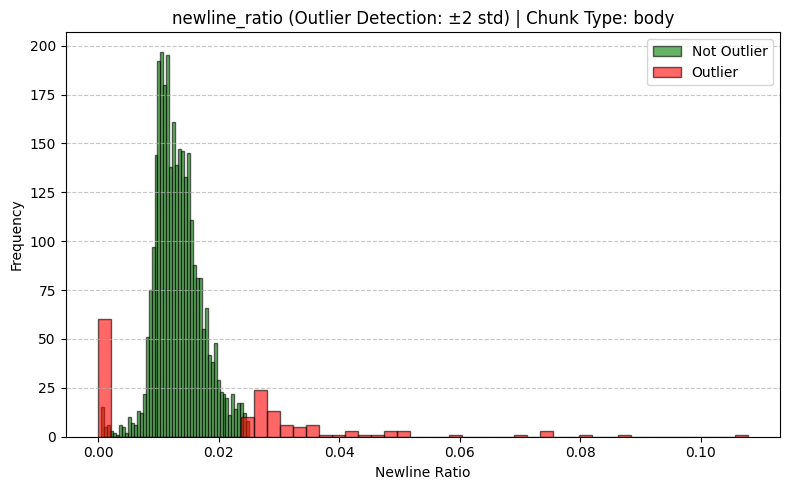

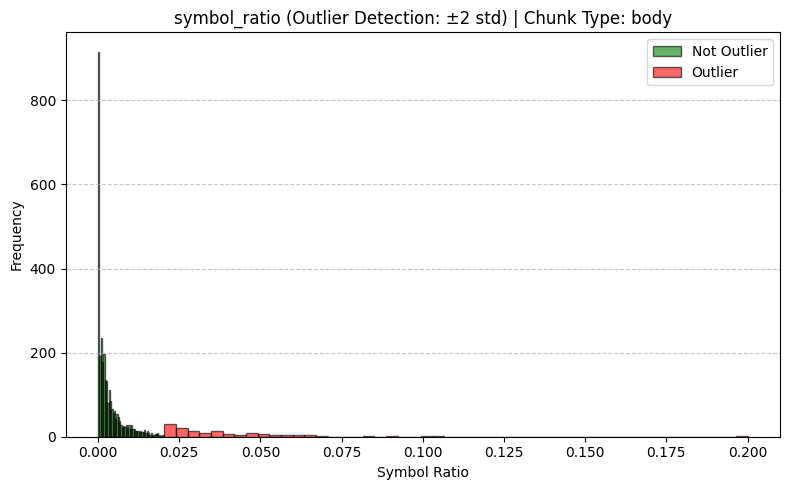

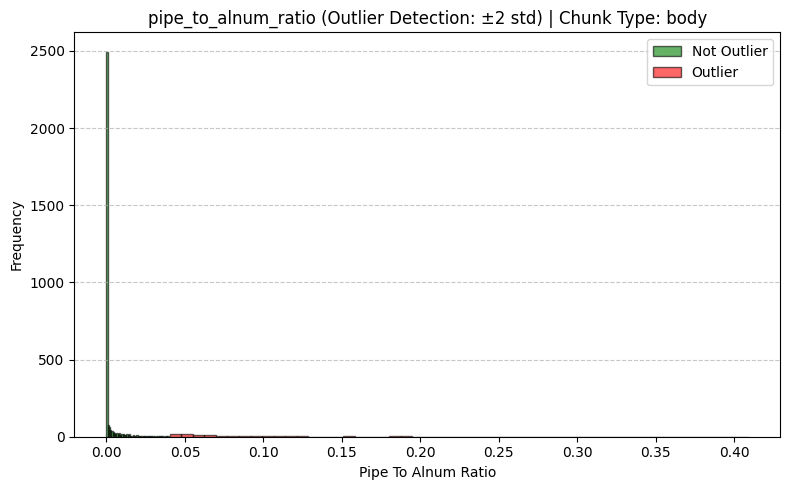

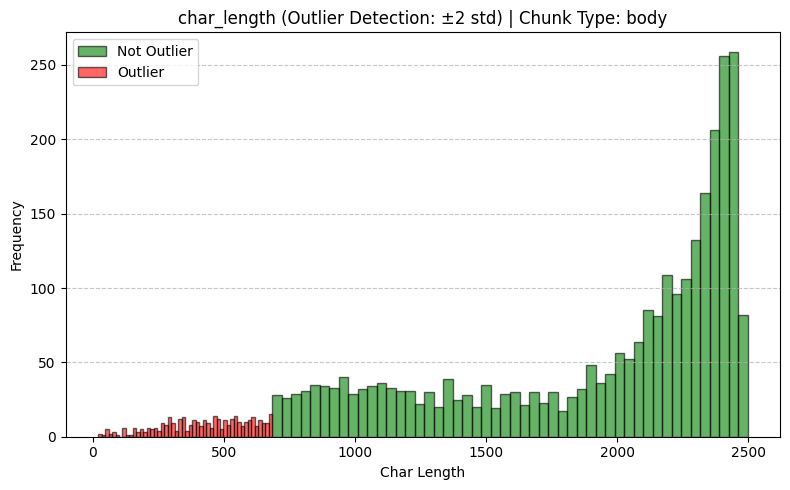

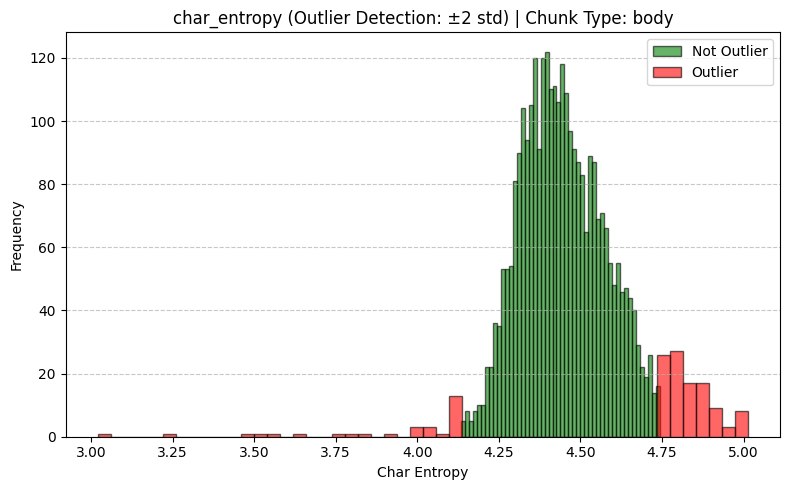

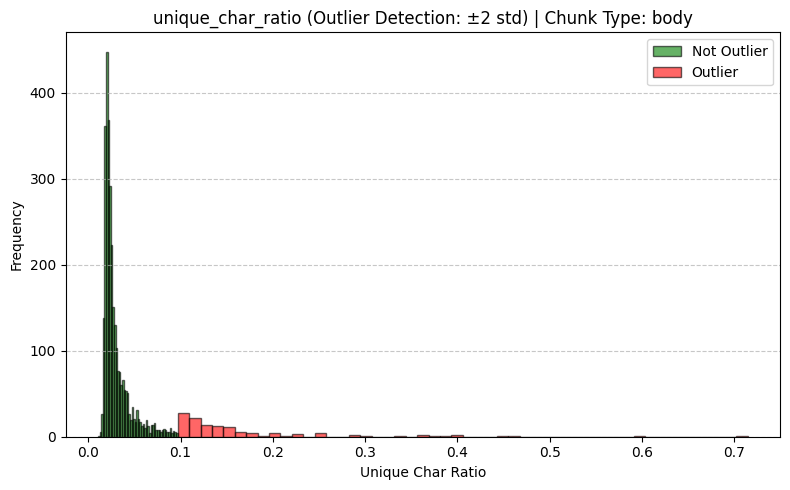

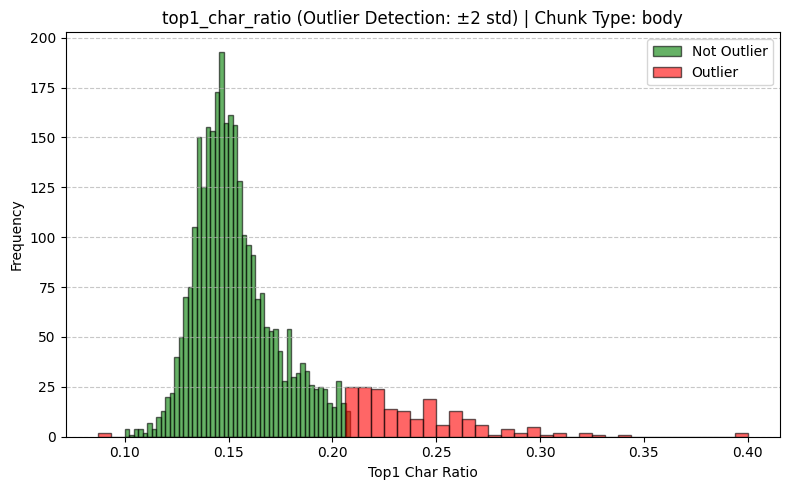

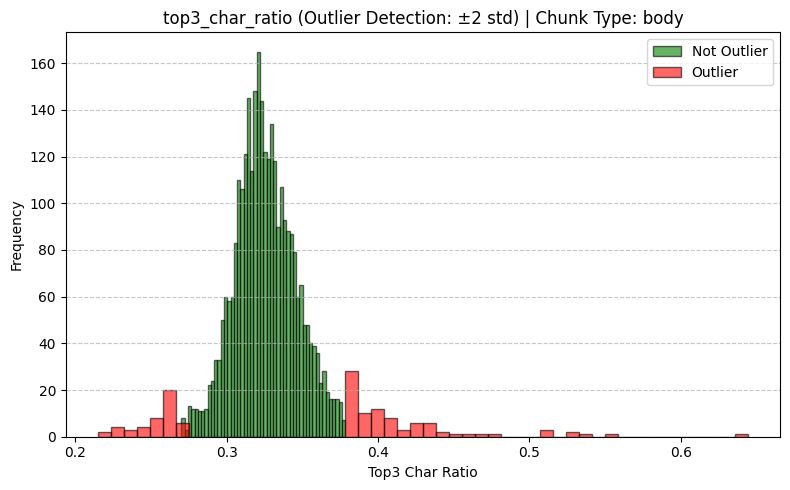

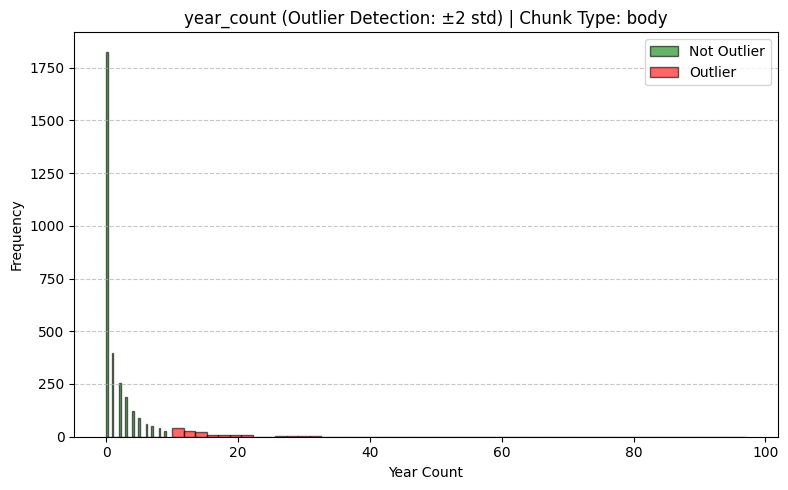

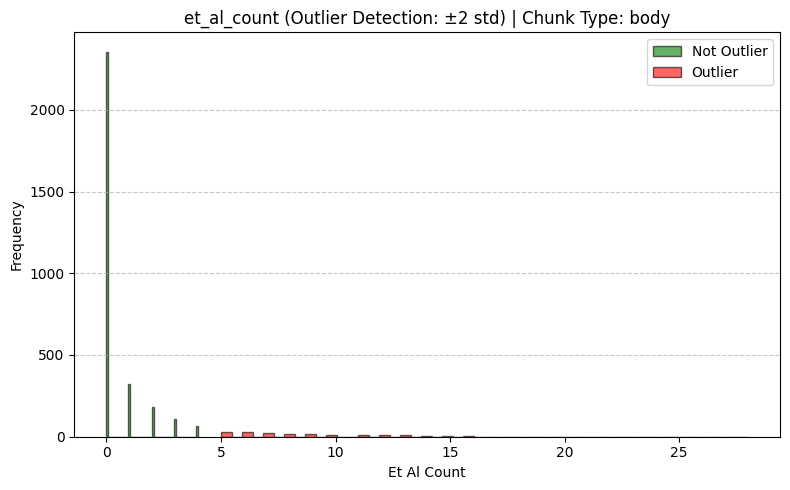

/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


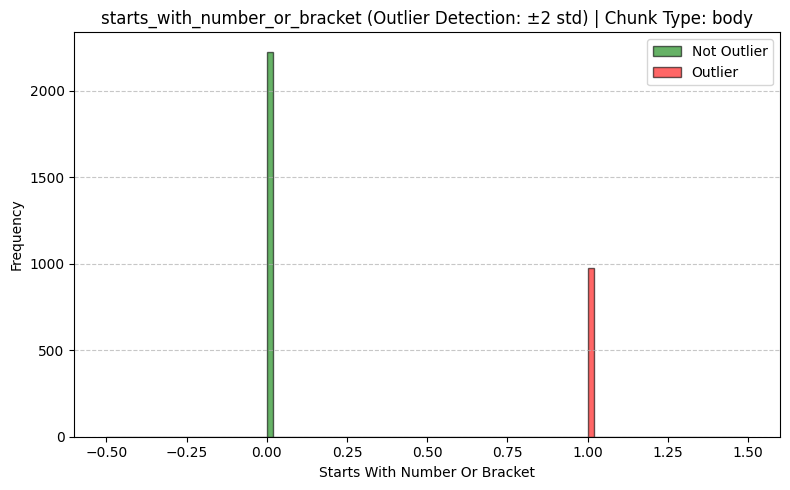

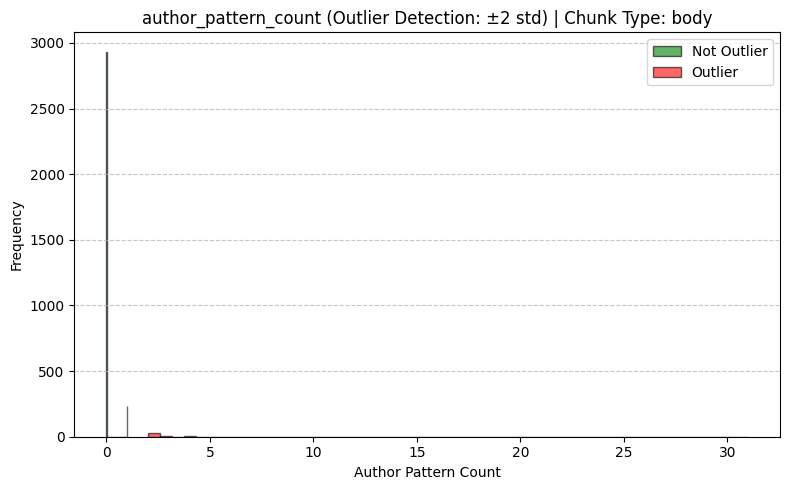

In [27]:
body_character_metrics_summary_df = summarize_char_metrics_from_dataset(hand_labled_dataset_XGB_dataset, filter_field="human_label_chunk_type", filter_value="body")

std_multiplier = 2

body_outliers_by_metric = get_outlier_indices_by_metric(
    dataset=hand_labled_dataset_XGB_dataset,
    summary_df=body_character_metrics_summary_df,
    std_multiplier=std_multiplier,
    filter_field="human_label_chunk_type",
    filter_value="body"
)

# Plot histograms directly from the HF dataset
plot_metric_outlier_histograms_from_hf_dataset(
    hf_dataset=hand_labled_dataset_XGB_dataset,
    outlier_indices_dict=body_outliers_by_metric,
    metrics_summary=body_character_metrics_summary_df,
    std_multiplier=std_multiplier,
    filter_field="human_label_chunk_type",
    filter_value="body"
)

Filter:   0%|          | 0/4445 [00:00<?, ? examples/s]

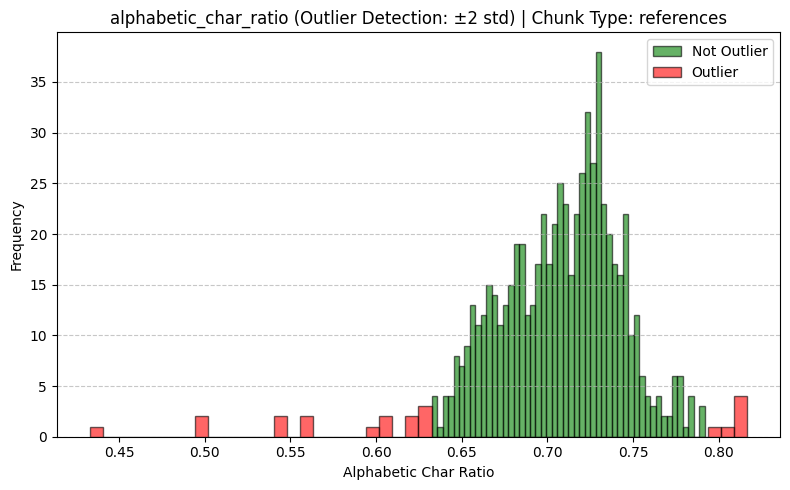

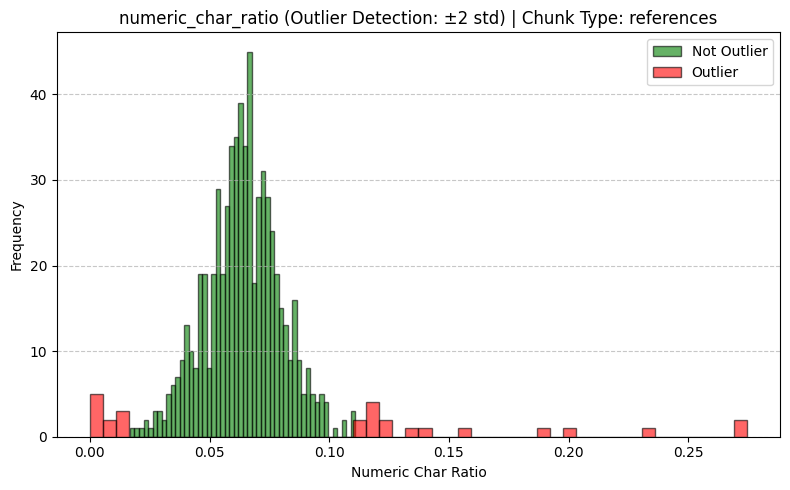

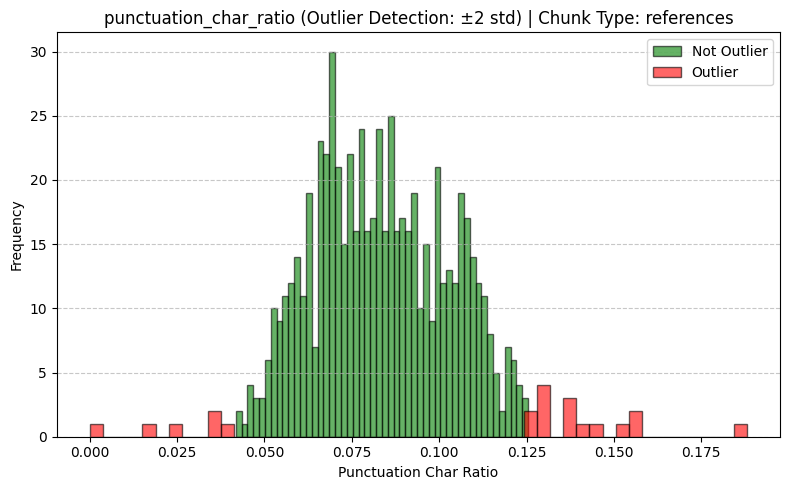

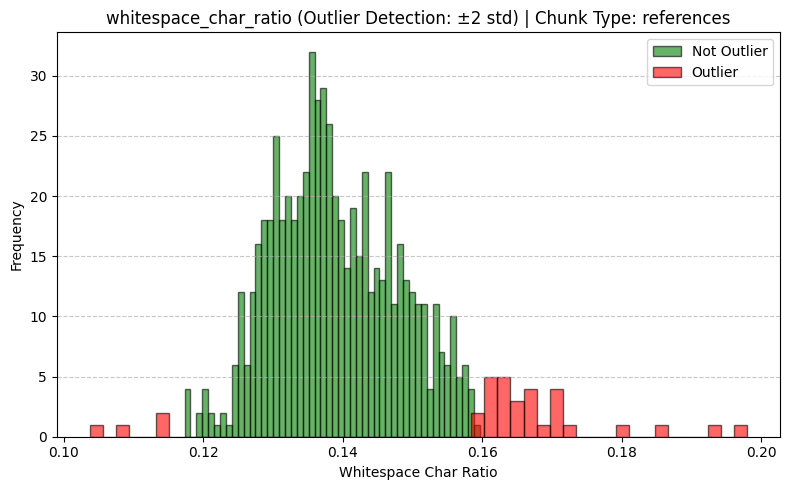

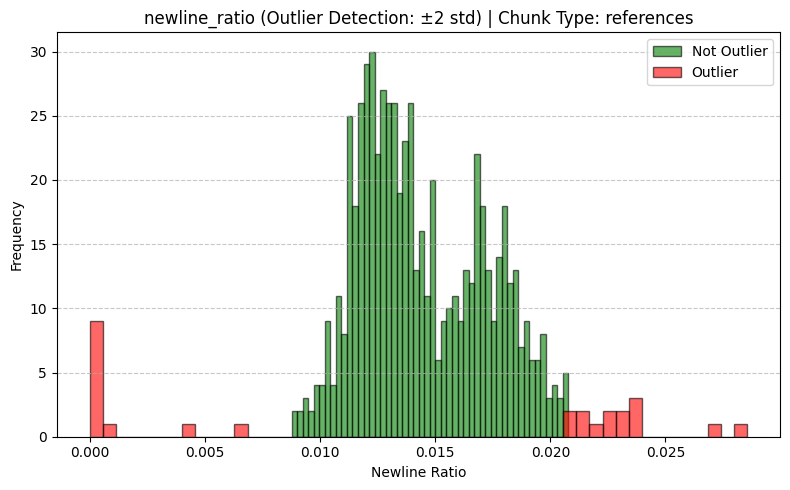

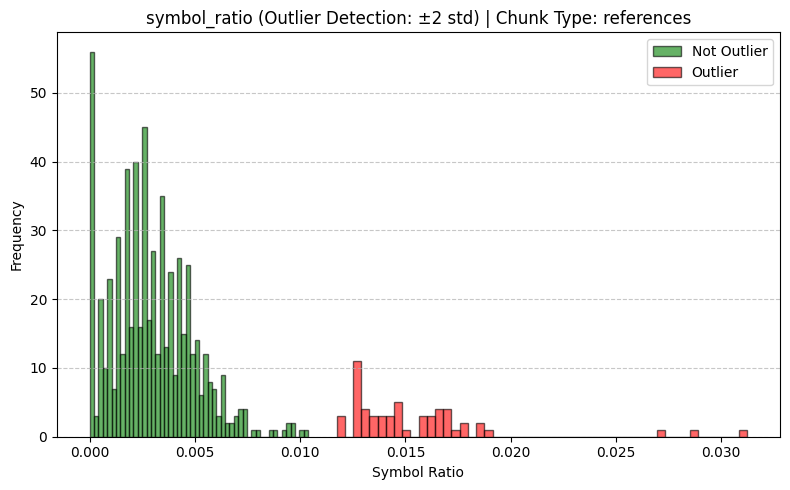

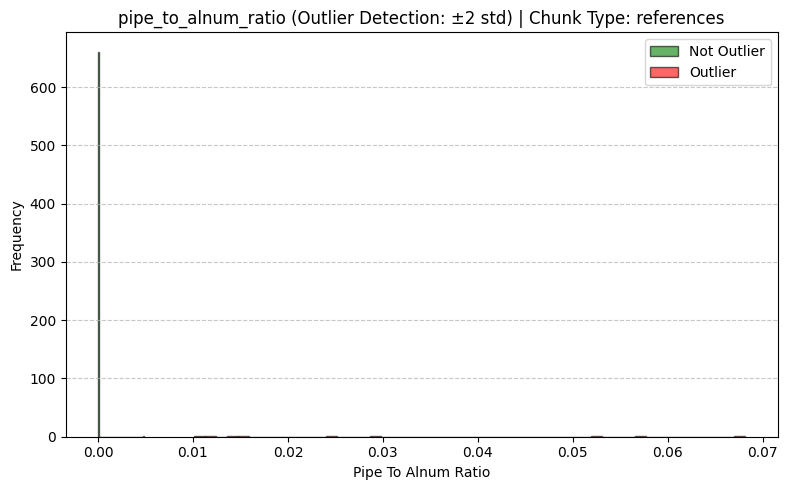

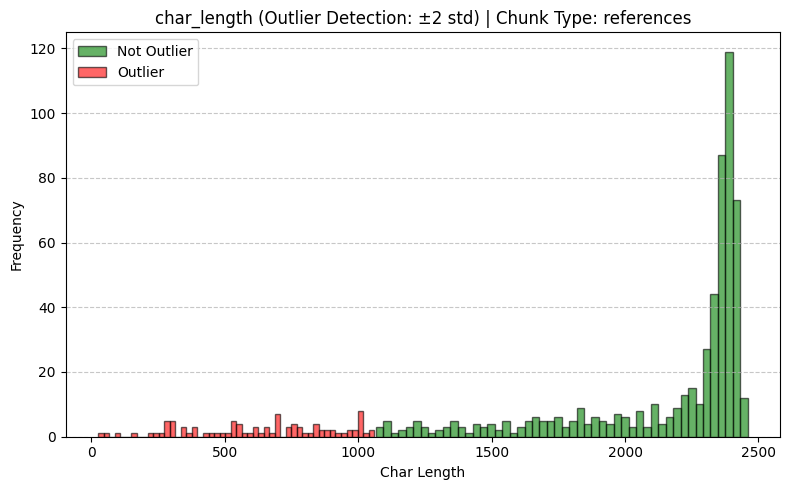

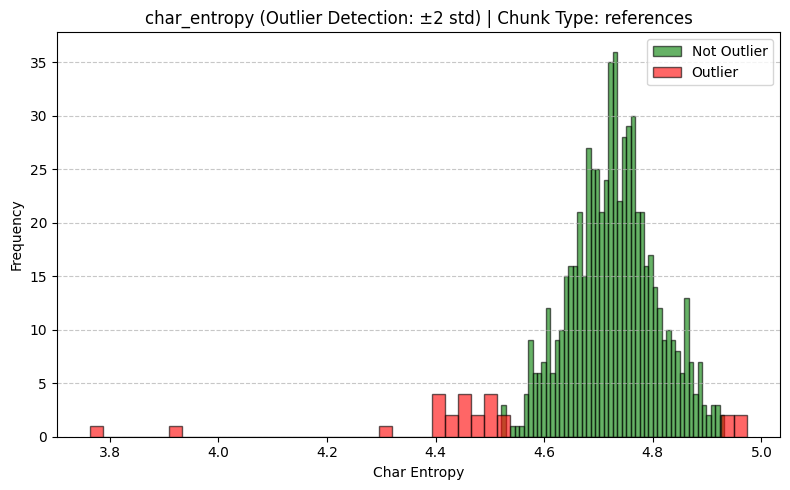

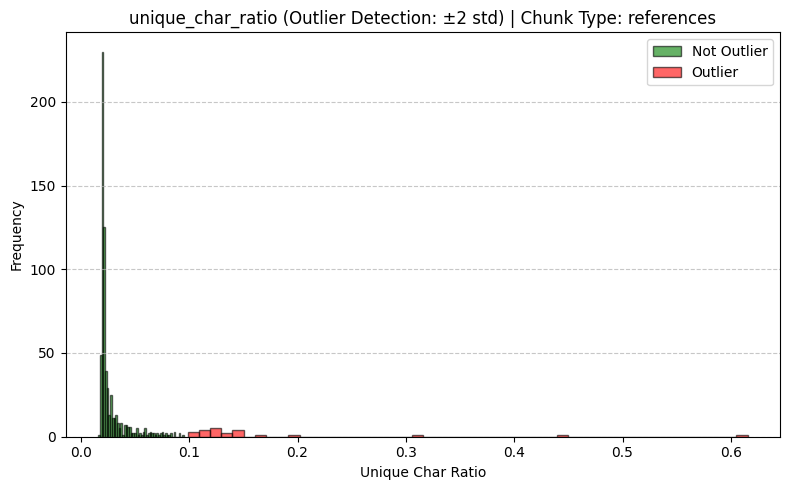

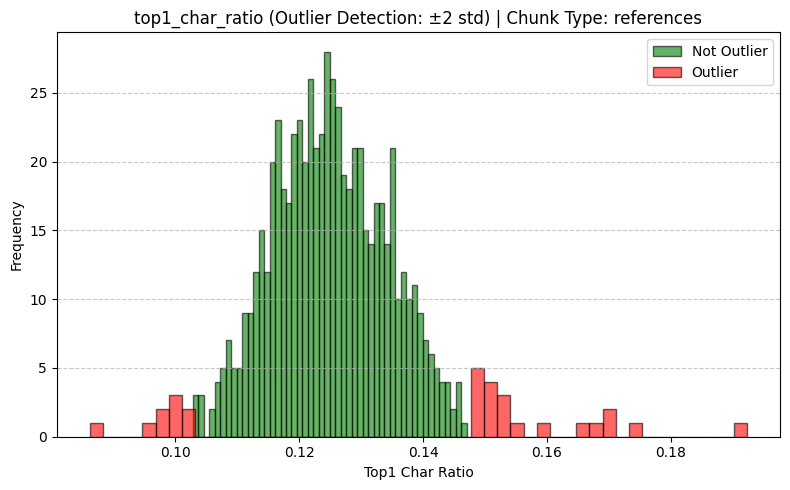

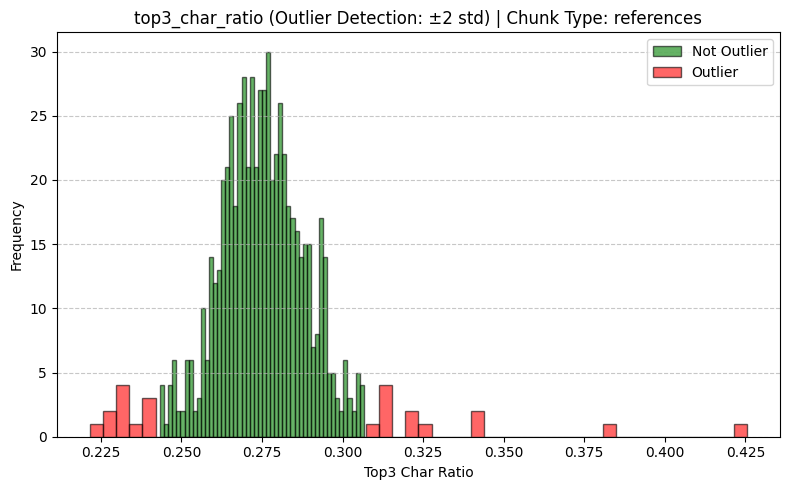

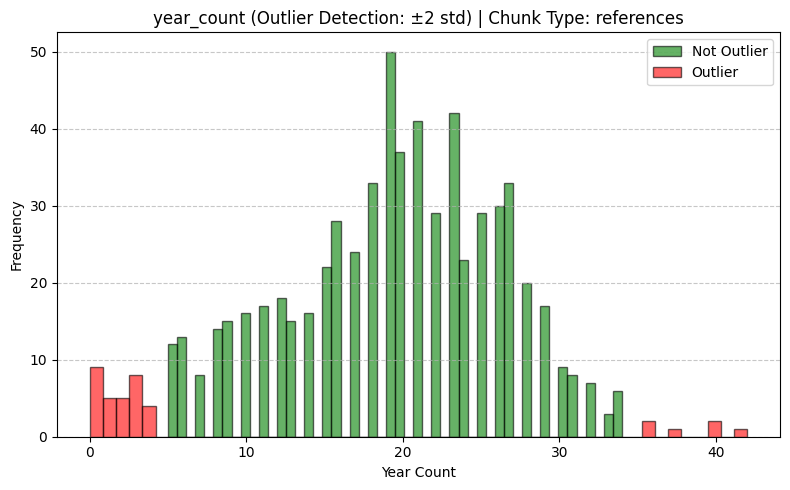

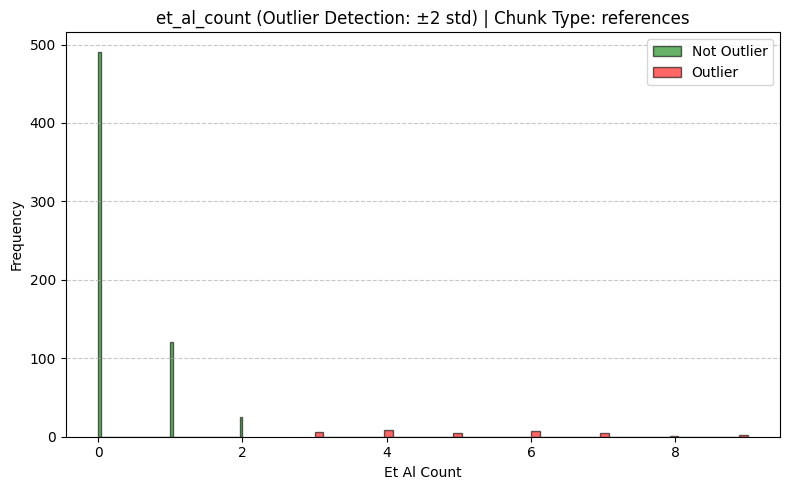

/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


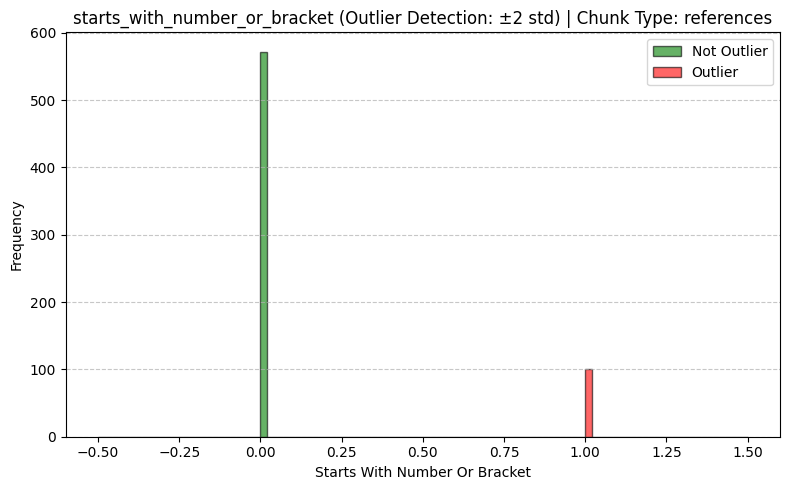

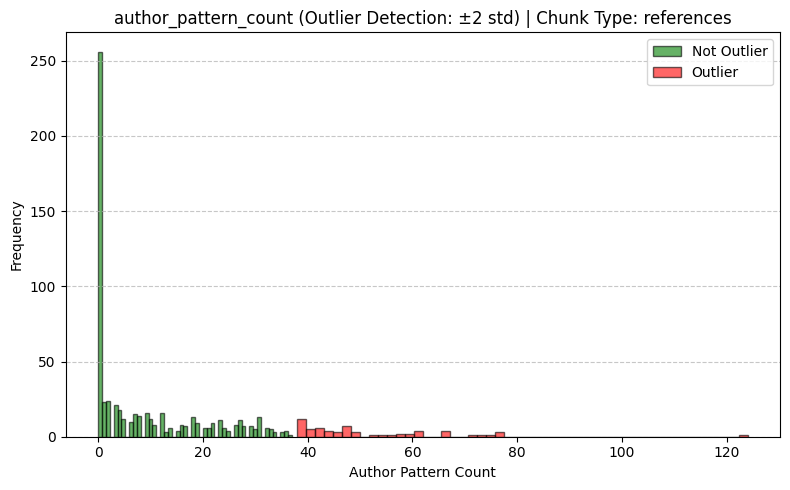

In [28]:
references_character_metrics_summary_df = summarize_char_metrics_from_dataset(hand_labled_dataset_XGB_dataset, filter_field="human_label_chunk_type", filter_value="references")

references_outliers_by_metric = get_outlier_indices_by_metric(
    dataset=hand_labled_dataset_XGB_dataset,
    summary_df=references_character_metrics_summary_df,
    std_multiplier=std_multiplier,
    filter_field="human_label_chunk_type",
    filter_value="references"
)

# Plot histograms directly from the HF dataset
plot_metric_outlier_histograms_from_hf_dataset(
    hf_dataset=hand_labled_dataset_XGB_dataset,
    outlier_indices_dict=references_outliers_by_metric,
    metrics_summary=references_character_metrics_summary_df,
    std_multiplier=std_multiplier,
    filter_field="human_label_chunk_type",
    filter_value="references"
)

In [29]:
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['plaintext', 'chunk_type', 'human_label_chunk_type', 'alphabetic_char_ratio', 'numeric_char_ratio', 'punctuation_char_ratio', 'whitespace_char_ratio', 'newline_ratio', 'symbol_ratio', 'pipe_to_alnum_ratio', 'char_length', 'char_entropy', 'unique_char_ratio', 'top1_char_ratio', 'top3_char_ratio', 'year_count', 'et_al_count', 'starts_with_number_or_bracket', 'author_pattern_count'],
    num_rows: 4445
})

In [30]:
from datasets import Dataset

# Assuming your dataset is called `hf_dataset`
body_chunks = hand_labled_dataset_XGB_dataset.filter(lambda x: x['human_label_chunk_type'] == 'body')
references_chunks = hand_labled_dataset_XGB_dataset.filter(lambda x: x['human_label_chunk_type'] == 'references')

Filter:   0%|          | 0/4445 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4445 [00:00<?, ? examples/s]

In [31]:
# Convert Hugging Face dataset to pandas DataFrame
body_chunks_df = body_chunks.to_pandas()
references_chunks_df = references_chunks.to_pandas()

In [32]:
body_chunks_df

,plaintext,chunk_type,human_label_chunk_type,alphabetic_char_ratio,numeric_char_ratio,punctuation_char_ratio,whitespace_char_ratio,newline_ratio,symbol_ratio,pipe_to_alnum_ratio,char_length,char_entropy,unique_char_ratio,top1_char_ratio,top3_char_ratio,year_count,et_al_count,starts_with_number_or_bracket,author_pattern_count
0,Abstract\nWe describe an approach to domain ad...,body,body,0.807128,0.004193,0.023061,0.157233,0.016771,0.008386,0.000000,477,4.316919,0.073375,0.140461,0.327044,0,0,False,0
1,1 Introduction\nThe task of domain adaptation ...,body,body,0.807203,0.003708,0.024894,0.161547,0.013771,0.002648,0.000000,1888,4.308978,0.021716,0.147775,0.328919,0,0,True,0
2,2 Problem Formalization and Prior Work\nTo fac...,body,body,0.764557,0.004641,0.036709,0.189030,0.017722,0.005063,0.000000,2370,4.370650,0.021941,0.171308,0.351055,1,0,True,0
3,"In the L IN I NT baseline, we linearly interpo...",body,body,0.776366,0.012283,0.035155,0.171114,0.013554,0.005083,0.004296,2361,4.391371,0.019907,0.157560,0.336298,5,0,False,0
4,3 Adaptation by Feature Augmentation\nIn this ...,body,body,0.746118,0.009232,0.047419,0.182543,0.013848,0.014687,0.000000,2383,4.532780,0.023500,0.168695,0.326899,0,0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,"Transformer in Transformer\nKai Han [1] [,] [2...",title,body,0.792528,0.010007,0.053369,0.143429,0.014009,0.000667,0.000000,1499,4.562893,0.032688,0.129420,0.294196,0,0,False,0
3201,MLP-Mixer: An all-MLP Architecture for Vision\...,title,body,0.801894,0.000728,0.056810,0.134013,0.015295,0.006555,0.000000,1373,4.548372,0.031318,0.118718,0.277495,0,0,False,0
3202,LoRA: Low-Rank Adaptation of Large Language Mo...,title,body,0.806089,0.011251,0.041694,0.139643,0.015222,0.001324,0.000000,1511,4.503706,0.030443,0.124421,0.299140,0,0,False,0
3203,Scaling Instruction-Finetuned Language Models\...,title,body,0.783237,0.014933,0.056358,0.141618,0.013487,0.003854,0.000000,2076,4.659896,0.025530,0.128131,0.279383,0,0,False,0


In [33]:
references_chunks_df

,plaintext,chunk_type,human_label_chunk_type,alphabetic_char_ratio,numeric_char_ratio,punctuation_char_ratio,whitespace_char_ratio,newline_ratio,symbol_ratio,pipe_to_alnum_ratio,char_length,char_entropy,unique_char_ratio,top1_char_ratio,top3_char_ratio,year_count,et_al_count,starts_with_number_or_bracket,author_pattern_count
0,References\n[Ben-David et al.2006] Shai Ben-Da...,references,references,0.746704,0.049271,0.070090,0.129077,0.016655,0.004858,0.0,1441,4.659717,0.034004,0.112422,0.269951,11,3,False,0
1,References\n[Akaike 74] H. Akaike. A new look ...,references,references,0.674300,0.089059,0.100085,0.135708,0.000848,0.000848,0.0,1179,4.716700,0.037320,0.134860,0.271416,9,1,False,2
2,[Hagiwara 02] K. Hagiwara. On the problem in m...,references,references,0.684235,0.086754,0.088619,0.138993,0.000000,0.001399,0.0,2144,4.732446,0.021455,0.138993,0.274720,21,2,True,7
3,"[van der Vaart 96] A. W. van der Vaart, J. A. ...",references,references,0.700145,0.079672,0.086432,0.133752,0.000000,0.000000,0.0,2071,4.667340,0.020763,0.133752,0.296958,18,0,True,3
4,6 FUTURE WORK\nWe show that by batching over i...,body,references,0.773883,0.023225,0.055215,0.147677,0.018405,0.000000,0.0,2282,4.516310,0.019281,0.129273,0.295793,13,0,True,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,summarization. arXiv preprint arXiv:1705.04304...,references,references,0.718997,0.074315,0.066419,0.137947,0.013005,0.002322,0.0,2153,4.810922,0.023223,0.124942,0.270320,21,1,False,0
668,"References\nBengio, Yoshua, Goodfellow, Ian J,...",references,references,0.718854,0.052326,0.087625,0.137874,0.018688,0.003322,0.0,2408,4.686599,0.019518,0.119186,0.269103,20,2,False,0
669,"neural networks. In ICLR, 2017.\nHinton, Geoff...",references,references,0.736418,0.060272,0.070458,0.130306,0.017402,0.002547,0.0,2356,4.731772,0.019949,0.112903,0.267402,24,0,False,0
670,"2324, 1998.\nSu pp lementar y Materials: On Ca...",references,references,0.736624,0.054334,0.076732,0.129822,0.017005,0.002489,0.0,2411,4.726067,0.019079,0.112816,0.253837,23,1,True,7


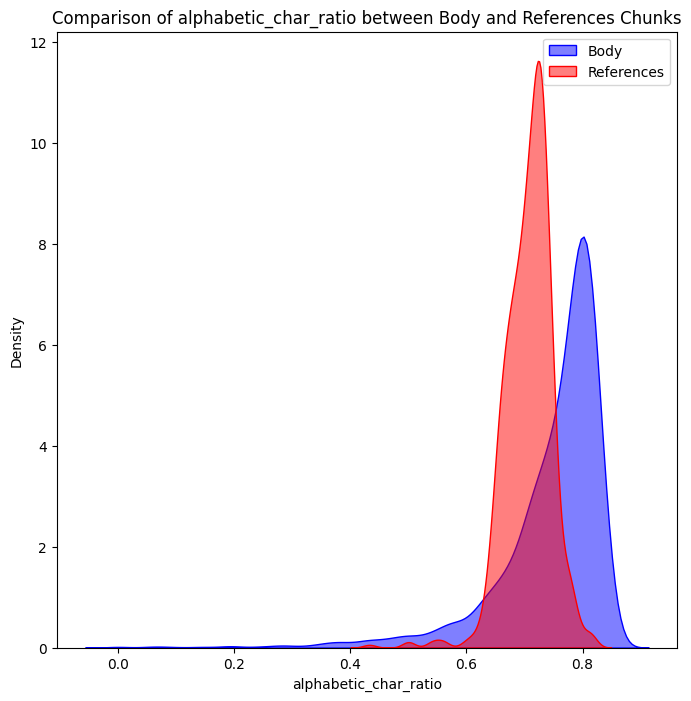

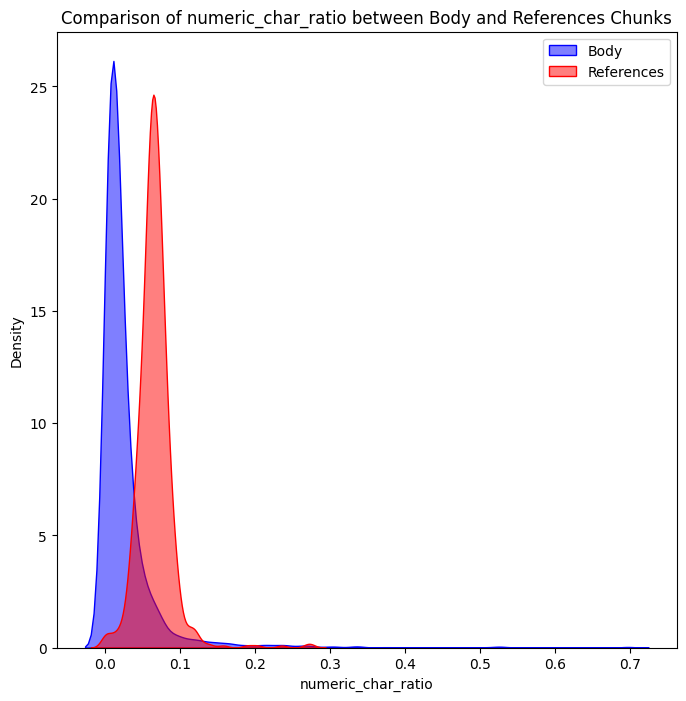

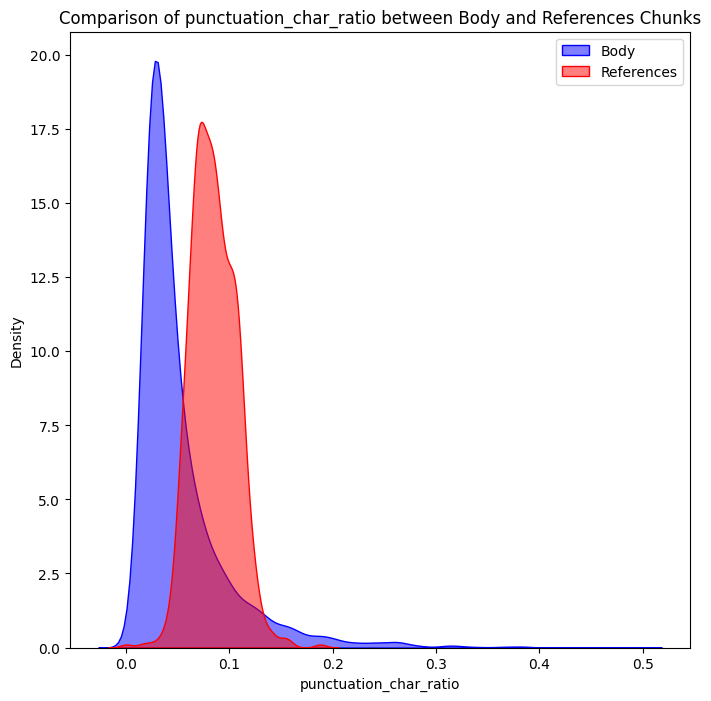

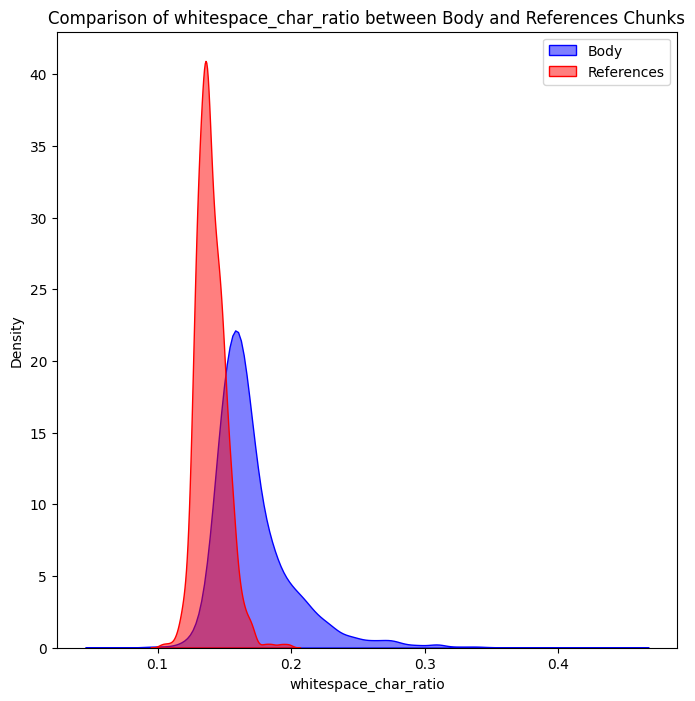

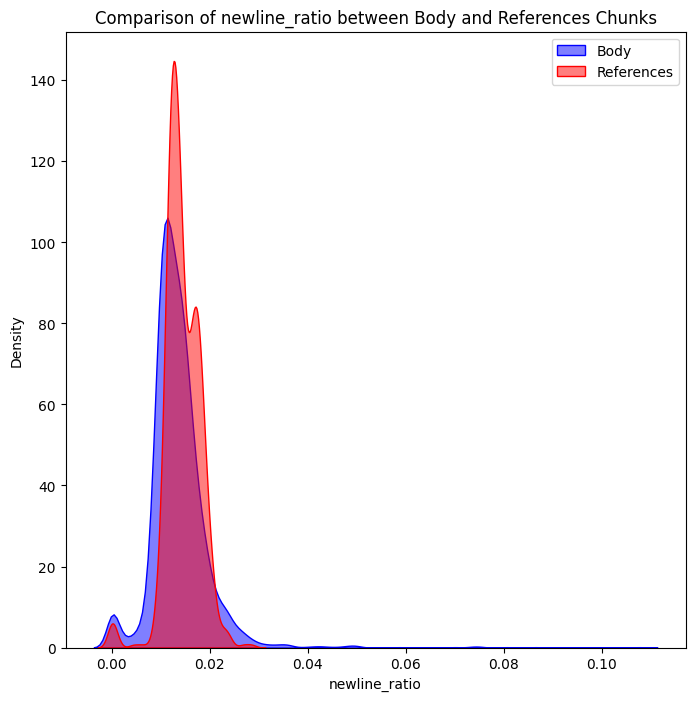

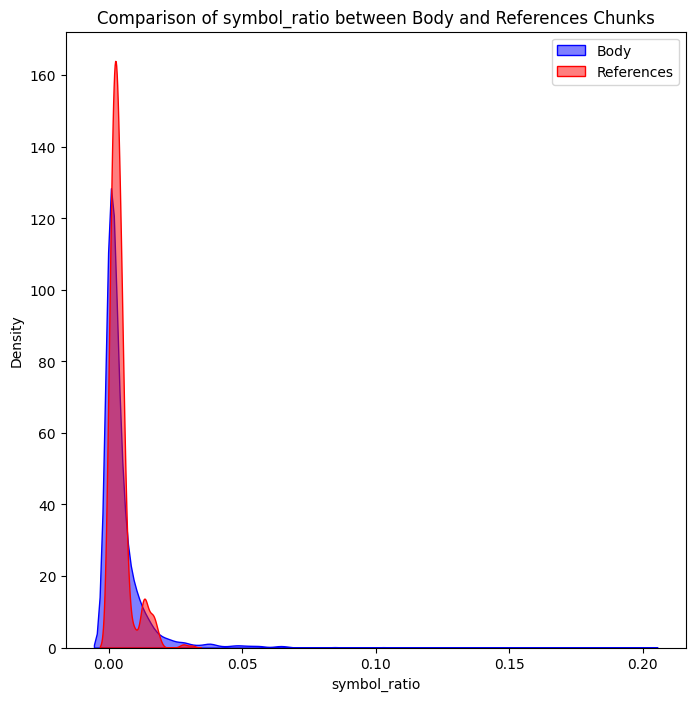

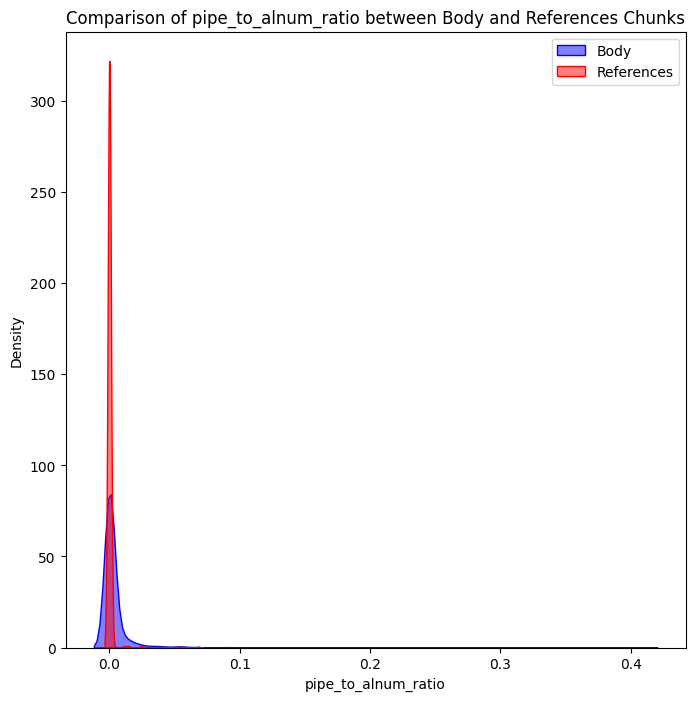

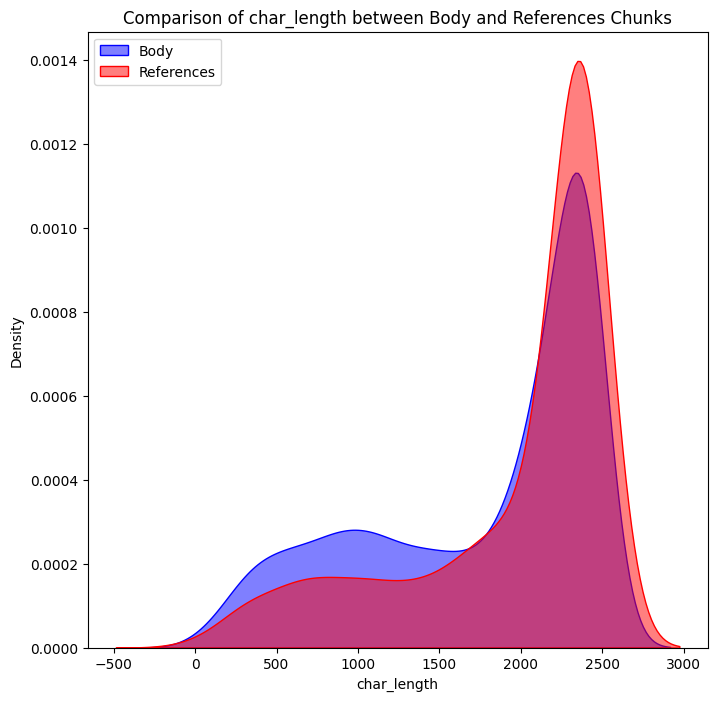

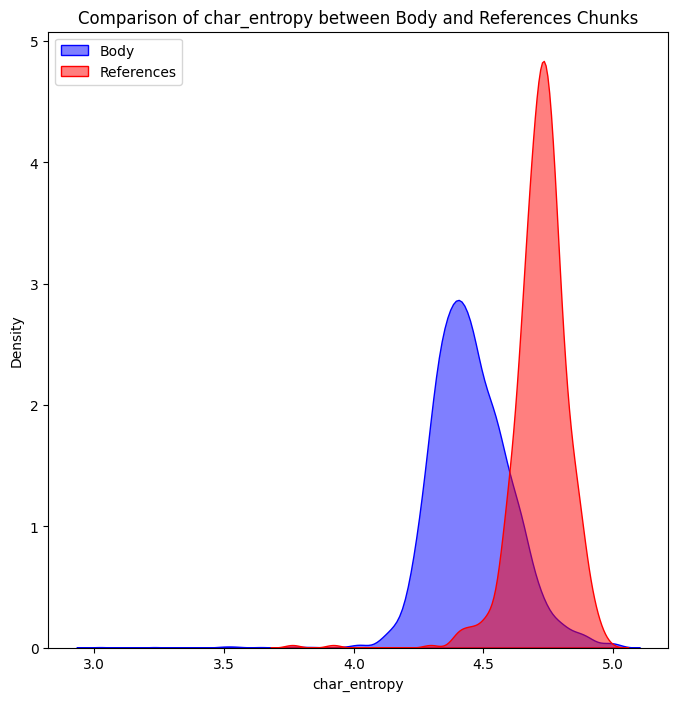

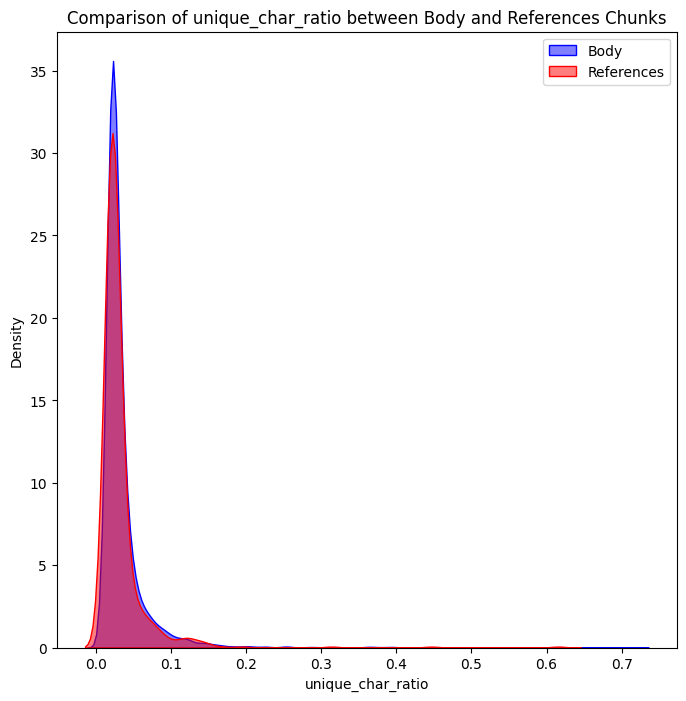

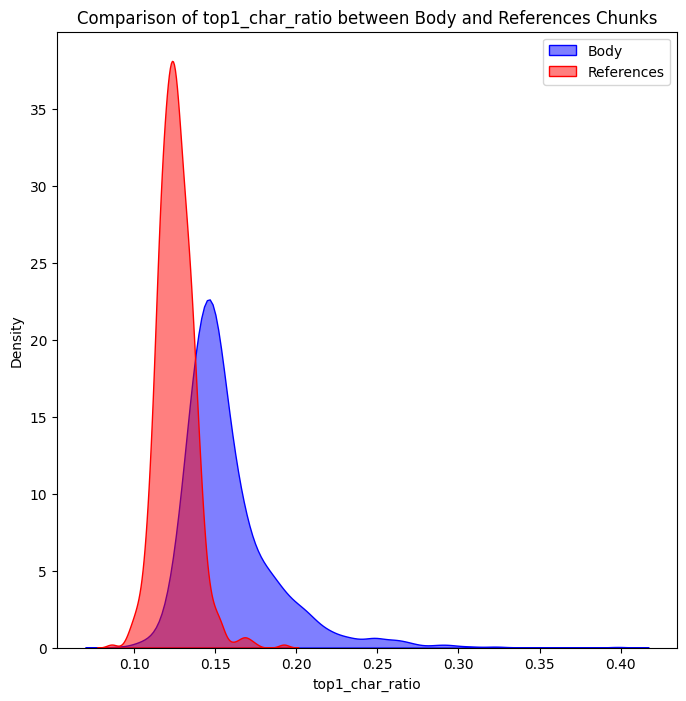

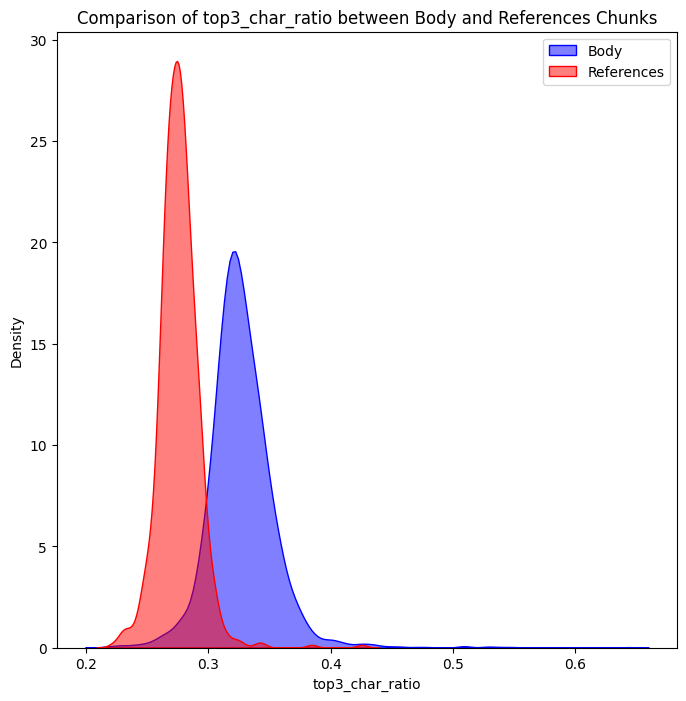

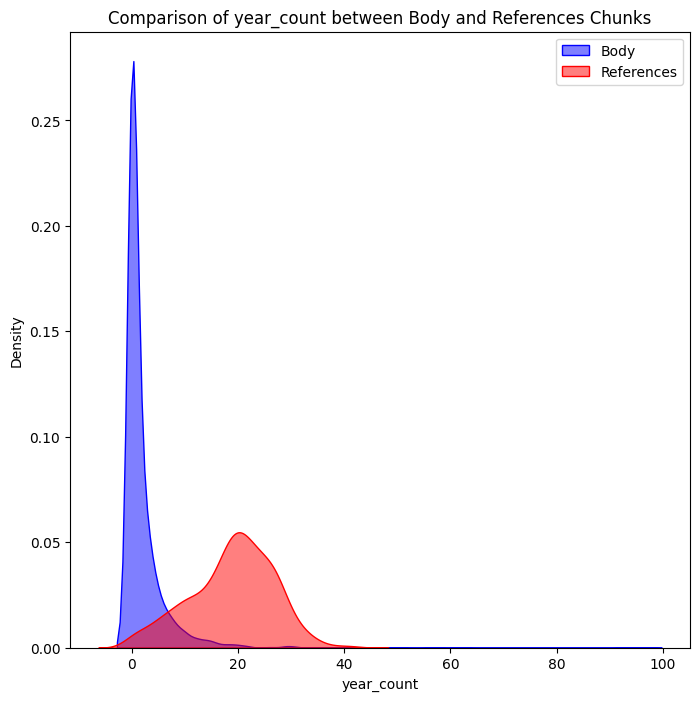

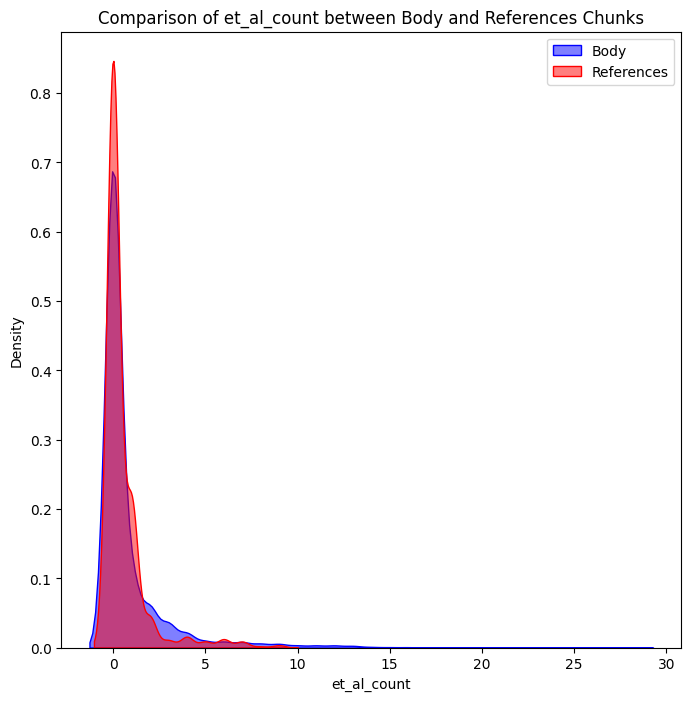

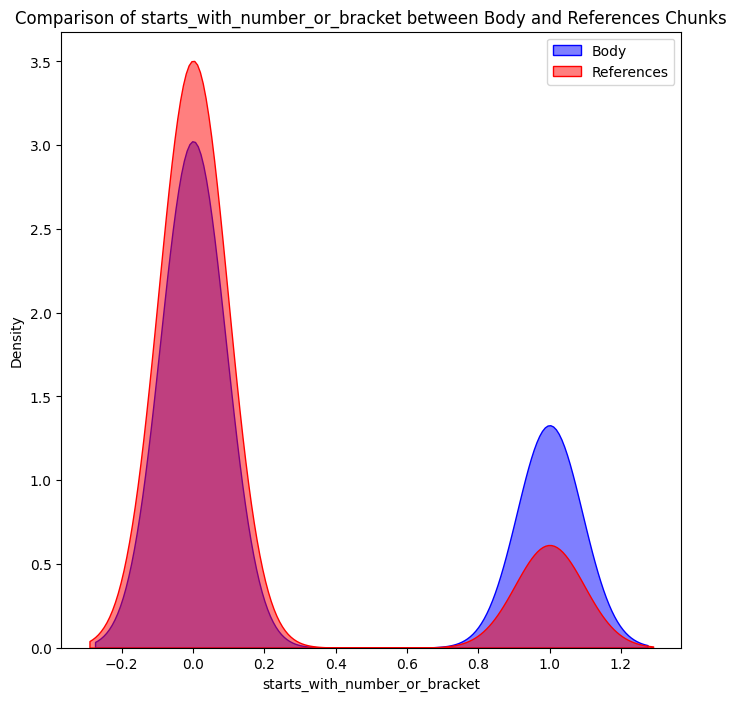

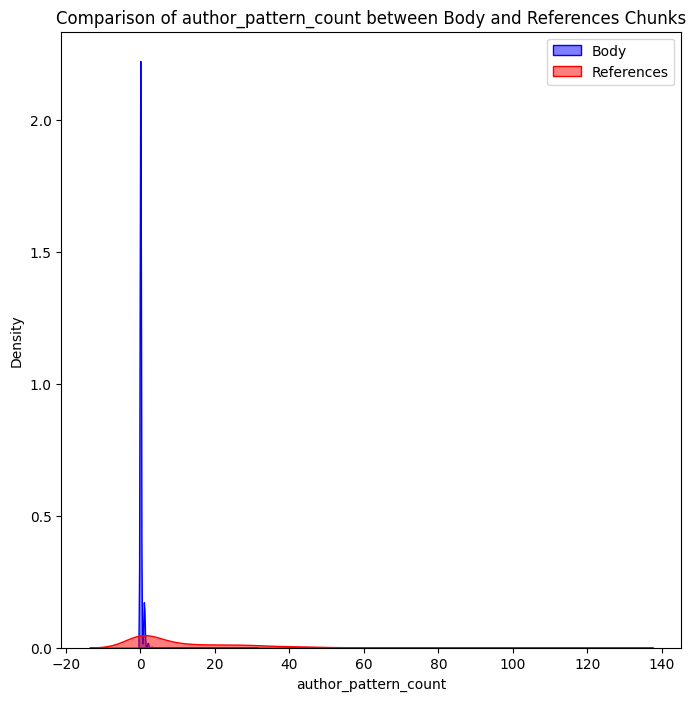

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_comparison(body_chunks_df, references_chunks_df, feature_name):
    """
    Visualizes the comparison between body and reference chunks for a specific feature.

    Parameters:
    - df (DataFrame): The DataFrame containing the dataset.
    - body_chunks_df (DataFrame): Chunks labeled as 'body'.
    - references_chunks_df (DataFrame): Chunks labeled as 'references'.
    - feature_name (str): The feature column name to compare.
    """

    plt.figure(figsize=(8, 8))

    # Plot for body chunks
    sns.kdeplot(body_chunks_df[feature_name], label='Body', fill=True, color='blue', alpha=0.5)

    # Plot for reference chunks
    sns.kdeplot(references_chunks_df[feature_name], label='References', fill=True, color='red', alpha=0.5)

    plt.title(f"Comparison of {feature_name} between Body and References Chunks")
    plt.xlabel(feature_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

my_metrics = character_metrics_summary_df.Metric.to_list()

for metric in my_metrics:
  # Example for comparing 'char_length' feature
  plot_feature_comparison(body_chunks_df, references_chunks_df, metric)

In [35]:
hand_labled_dataset_XGB_dataset

Dataset({
    features: ['plaintext', 'chunk_type', 'human_label_chunk_type', 'alphabetic_char_ratio', 'numeric_char_ratio', 'punctuation_char_ratio', 'whitespace_char_ratio', 'newline_ratio', 'symbol_ratio', 'pipe_to_alnum_ratio', 'char_length', 'char_entropy', 'unique_char_ratio', 'top1_char_ratio', 'top3_char_ratio', 'year_count', 'et_al_count', 'starts_with_number_or_bracket', 'author_pattern_count'],
    num_rows: 4445
})

In [36]:
# Convert to pandas DataFrame for splitting
model_df = hand_labled_dataset_XGB_dataset.to_pandas()
model_df['chunk_type'] = model_df['chunk_type'].astype('category')
model_df['human_label_chunk_type'] = model_df['human_label_chunk_type'].astype('category')

In [37]:
print(model_df.columns.to_list())

['plaintext', 'chunk_type', 'human_label_chunk_type', 'alphabetic_char_ratio', 'numeric_char_ratio', 'punctuation_char_ratio', 'whitespace_char_ratio', 'newline_ratio', 'symbol_ratio', 'pipe_to_alnum_ratio', 'char_length', 'char_entropy', 'unique_char_ratio', 'top1_char_ratio', 'top3_char_ratio', 'year_count', 'et_al_count', 'starts_with_number_or_bracket', 'author_pattern_count']


In [38]:
drop_features = model_df.columns.to_list()[:3]
drop_features

['plaintext', 'chunk_type', 'human_label_chunk_type']

In [39]:
X = model_df.drop(columns=drop_features)
y = model_df['human_label_chunk_type']

In [40]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import numpy as np

def train_and_evaluate_xgboost_with_validation(X, y, test_size=0.2, random_state=42, cv_folds=5):
    """
    Function to train and evaluate an XGBoost classifier with cross-validation.

    Parameters:
    - X: Features (DataFrame or numpy array)
    - y: Target variable (categorical labels)
    - test_size: Proportion of data to use for testing (default 0.2)
    - random_state: Seed for reproducibility (default 42)
    - cv_folds: Number of folds for cross-validation (default 5)

    Returns:
    - None: Prints classification report and cross-validation performance
    """

    # Split the data into training and test sets (stratified split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Apply StandardScaler to the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encode the target labels if necessary
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Initialize the XGBoost classifier
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    # Cross-validation performance
    cv_scores = cross_val_score(clf, X_train_scaled, y_train_encoded, cv=cv_folds, scoring='accuracy')

    print(f"Cross-validation performance (accuracy): {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of CV accuracy: {cv_scores.std():.4f}")

    # Train the model on the entire training set
    clf.fit(X_train_scaled, y_train_encoded)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_scaled)

    # Print classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Example usage:
# Assuming you have a DataFrame 'df' with features and 'chunk_type' as the target column
# X = df[['token_count', 'avg_token_length', 'pos_noun_ratio']]  # Your feature columns
# y = df['chunk_type']  # Target variable

# Train, evaluate, and get cross-validation performance
train_and_evaluate_xgboost_with_validation(X, y)

/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:09] WARNING: /workspace/src/

Cross-validation performance (accuracy): [0.9508427  0.93670886 0.93530239 0.96061885 0.94936709]
Mean CV accuracy: 0.9466
Standard deviation of CV accuracy: 0.0095


/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report (Test Set):
              precision    recall  f1-score   support

        body       0.95      0.99      0.97       641
       noise       0.77      0.53      0.62        57
  references       0.98      0.96      0.97       134
       title       0.91      0.86      0.88        57

    accuracy                           0.95       889
   macro avg       0.90      0.83      0.86       889
weighted avg       0.94      0.95      0.94       889



In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
X_train

,alphabetic_char_ratio,numeric_char_ratio,punctuation_char_ratio,whitespace_char_ratio,newline_ratio,symbol_ratio,pipe_to_alnum_ratio,char_length,char_entropy,unique_char_ratio,top1_char_ratio,top3_char_ratio,year_count,et_al_count,starts_with_number_or_bracket,author_pattern_count
1,0.807128,0.004193,0.023061,0.157233,0.016771,0.008386,0.000000,477,4.316919,0.073375,0.140461,0.327044,0,0,False,0
2370,0.814037,0.008941,0.023692,0.153330,0.012964,0.000000,0.000000,2237,4.383125,0.019222,0.140367,0.311131,4,2,False,0
2774,0.700000,0.080000,0.000000,0.220000,0.000000,0.000000,0.000000,50,3.827363,0.420000,0.220000,0.460000,1,0,False,0
1976,0.779825,0.023278,0.037827,0.159069,0.011154,0.000000,0.000000,2062,4.470802,0.024248,0.147915,0.317168,1,0,False,0
1514,0.766683,0.028098,0.064727,0.139990,0.014551,0.000502,0.015152,1993,4.632445,0.024084,0.125439,0.275464,0,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.806780,0.010169,0.047458,0.135593,0.003390,0.000000,0.000000,295,4.431554,0.105085,0.132203,0.298305,0,0,True,0
2019,0.775693,0.031557,0.022601,0.166311,0.020896,0.003838,0.000000,2345,4.415110,0.020043,0.145416,0.318550,0,0,True,0
3118,0.737171,0.055779,0.044177,0.156627,0.019634,0.006247,0.000000,2241,4.640212,0.022311,0.136992,0.288264,10,5,False,0
1787,0.723385,0.011374,0.050500,0.202457,0.019108,0.012284,0.000000,2198,4.476957,0.024113,0.183348,0.349864,0,0,True,0


In [43]:
X_train['starts_with_number_or_bracket']

1       False
2370    False
2774    False
1976    False
1514    False
        ...  
1418     True
2019     True
3118    False
1787     True
3653    False
Name: starts_with_number_or_bracket, Length: 3556, dtype: bool

In [55]:
y_train

1             body
2370          body
2774         noise
1976          body
1514          body
           ...    
1418         noise
2019          body
3118          body
1787          body
3653    references
Name: human_label_chunk_type, Length: 3556, dtype: category
Categories (4, object): ['body', 'noise', 'references', 'title']

In [44]:
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib

def train_xgboost_with_crossval(X_train, y_train, n_splits=5, random_state=42):
    """
    Train an XGBoost model using 5-fold cross-validation on the training set.

    Parameters:
    - X_train: Features for the training set
    - y_train: Target variable for the training set
    - n_splits: Number of cross-validation splits (default 5)
    - random_state: Seed for reproducibility (default 42)

    Returns:
    - Trained model
    - LabelEncoder
    """

    # Encode the target labels as integers using LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_train)

    # Initialize the XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=random_state,
        use_label_encoder=False,  # skipping encoding of string categories to numbers
        eval_metric='mlogloss',
        objective='multi:softmax',  # Multi-class classification
        num_class=len(np.unique(y_encoded))  # Set this to the number of unique classes in your target
    )

    # 5-Fold Cross Validation on training set
    cross_val_results = cross_validate(xgb_model, X_train, y_encoded, cv=n_splits, return_estimator=True, scoring='accuracy')

    # Get the best model (from the first fold in this case)
    best_model = cross_val_results['estimator'][0]

    # Save the trained model to disk (optional)
    #joblib.dump(best_model, 'xgboost_model.pkl')

    # Report on train set performance (cross-validation results)
    print(f"Training Set Cross-Validation Accuracy: {cross_val_results['test_score'].mean():.4f}")

    return best_model, label_encoder

In [45]:
# Assuming you have the trained model from the previous code
# Train model (from the previous function)
model, label_encoder = train_xgboost_with_crossval(X_train, y_train)

/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:10] WARNING: /workspace/src/

Training Set Cross-Validation Accuracy: 0.9466


In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, label_encoder, X_test, y_test):
    """
    Evaluate the performance of the trained model on the test set.

    Parameters:
    - model: Trained XGBoost model
    - label_encoder: The label encoder used for encoding target variables
    - X_test: Features for test set
    - y_test: Target labels for test set

    Returns:
    - None: Prints classification report, accuracy, and confusion matrix
    """

    # Encode y_test using the same label encoder
    y_test_encoded = label_encoder.transform(y_test)

    # Apply the model to the test set
    y_test_pred = model.predict(X_test)

    # Evaluate performance
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("Test Classification Report:")
    print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

    # Confusion Matrix: Compute the confusion matrix for the test set
    cm_test = confusion_matrix(y_test_encoded, y_test_pred)

    # Plot the normalized confusion matrix for the test set
    cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Normalized Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Test Accuracy: 0.9404
Test Classification Report:
              precision    recall  f1-score   support

        body       0.95      0.99      0.97       641
       noise       0.76      0.54      0.63        57
  references       0.98      0.95      0.96       134
       title       0.85      0.79      0.82        57

    accuracy                           0.94       889
   macro avg       0.88      0.82      0.85       889
weighted avg       0.94      0.94      0.94       889



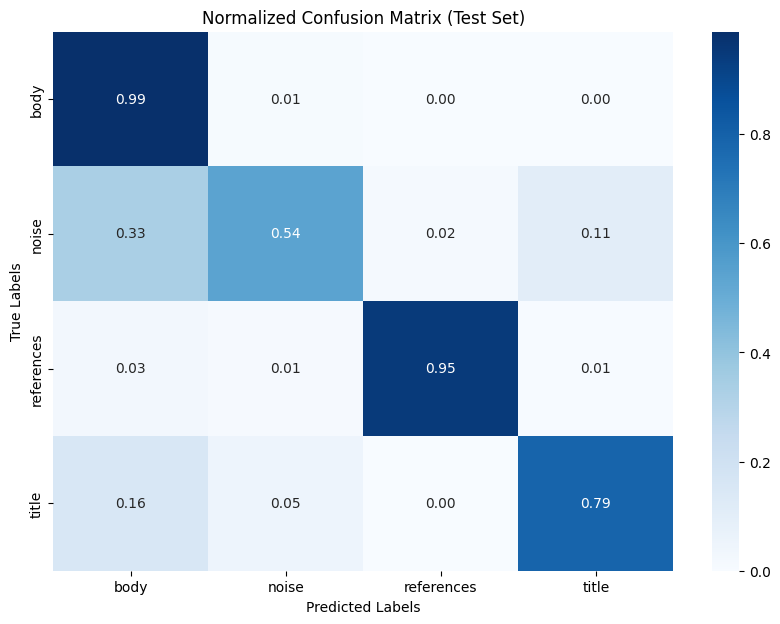

In [47]:
evaluate_model_on_test_set(model, label_encoder, X_test, y_test)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get feature names
feature_names = X.columns

# Get importance values from best model
importances = model.feature_importances_

# Create a DataFrame for easy viewing
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

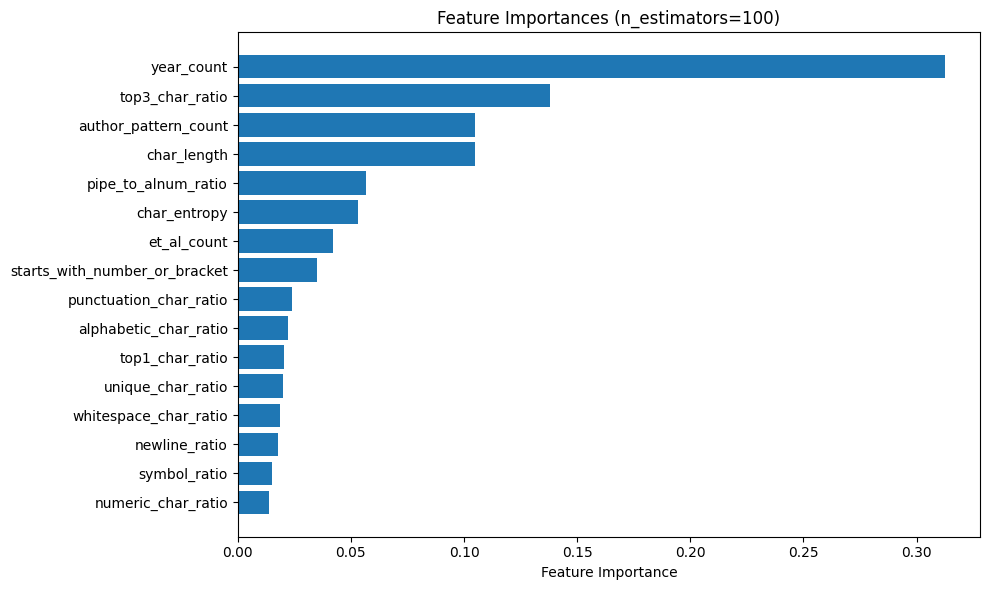

In [49]:
# Get the number of estimators (trees) from the trained XGBoost model
num_estimators = model.get_params()['n_estimators']

plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'][::-1], feat_df['Importance'][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Feature Importances (n_estimators={num_estimators})")
plt.tight_layout()
plt.show()

In [ ]:
keep_top_5_features = feat_df.head(5)['Feature'].to_list()
keep_top_5_features

['year_count',
 'top3_char_ratio',
 'author_pattern_count',
 'char_length',
 'pipe_to_alnum_ratio']

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Filter the original data to keep only the top 5 features
X_train_selected = X_train[keep_top_5_features]
X_test_selected = X_test[keep_top_5_features]

In [52]:
# Assuming you have the trained model from the previous code
# Train model (from the previous function)
model2, label_encoder2 = train_xgboost_with_crossval(X_train_selected, y_train)

/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:12] WARNING: /workspace/src/

Training Set Cross-Validation Accuracy: 0.9196


/home/marethu/NLP_Final_Project_Integrated/RagPythonLocal/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:40:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 0.9792
Test Classification Report:
              precision    recall  f1-score   support

        body       0.98      0.99      0.99      2564
       noise       0.94      0.86      0.90       225
  references       0.99      0.99      0.99       538
       title       0.93      0.92      0.92       229

    accuracy                           0.98      3556
   macro avg       0.96      0.94      0.95      3556
weighted avg       0.98      0.98      0.98      3556



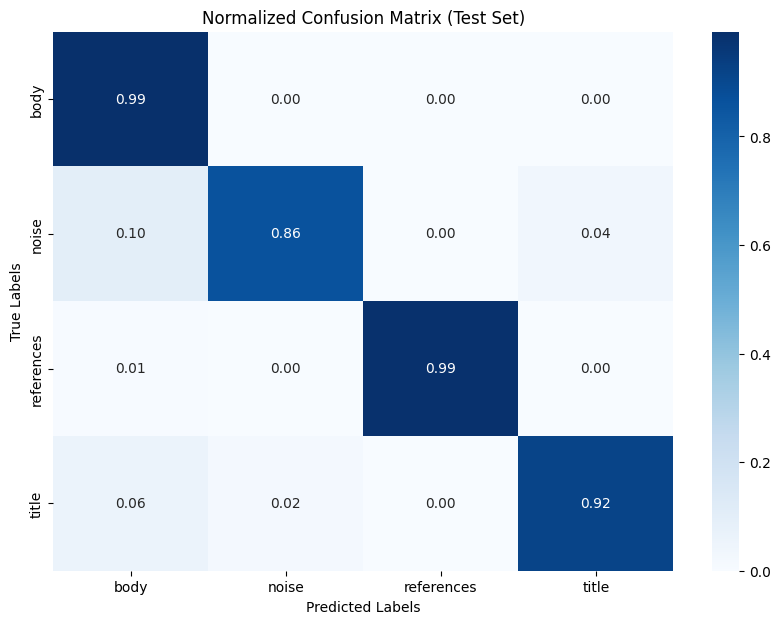

In [53]:
evaluate_model_on_test_set(model2, label_encoder2, X_train_selected, y_train)

Test Accuracy: 0.9201
Test Classification Report:
              precision    recall  f1-score   support

        body       0.94      0.97      0.95       641
       noise       0.71      0.51      0.59        57
  references       0.96      0.93      0.95       134
       title       0.74      0.75      0.75        57

    accuracy                           0.92       889
   macro avg       0.84      0.79      0.81       889
weighted avg       0.92      0.92      0.92       889



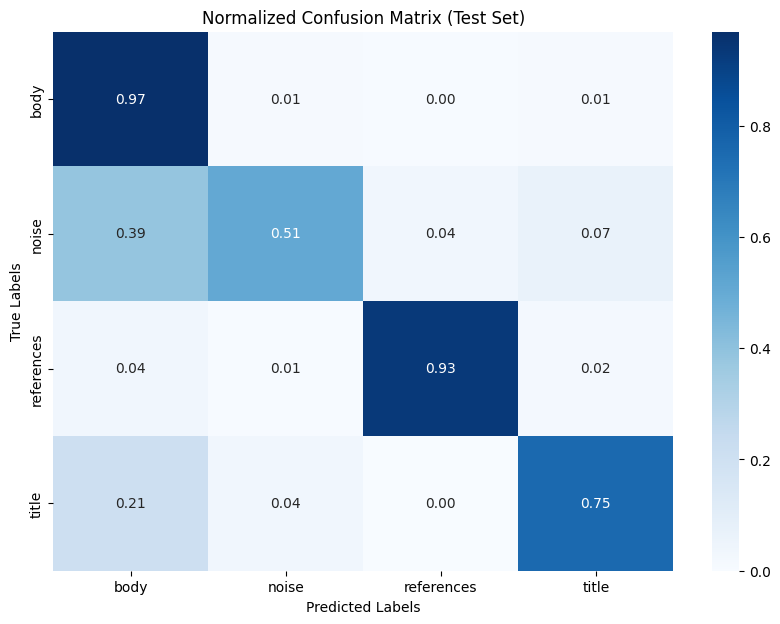

In [54]:
evaluate_model_on_test_set(model2, label_encoder2, X_test_selected, y_test)

# How to Proceed:

Grid search for a decently large number of iterations (say ~20-25 or so different xgboost 5 fold CV training calls) Get the top 10 models, and then examine their feature importance. When considering top 10 models, pay attention closely to the gap between train and validation performance, we want a model that has close performance between the two while scoring as high as possible. After that, we need to use the model to assign new predicted labels to the rest of the data (the unlabeled data). For your convenience I will get the unlabeled data below so you can see what to apply this method to. This will be an experiment that we can show once we have the RAG pipeline set up. The thing is that with this method we have a noise filter basically so hopefully it will improve the quality of our chunks. I also noticed some core behavior that influences the quality of our chunks that could probably be addressed by tweaking the chunking mechanism to deal with each chunk an additional time, but we don't want to go in to this (its gonna take too much time to change at this point, more value in the evaluation and testing for the retrieval metrics / training embedding model).